# Predicción del riesgo de enfermedad cardíaca: Tarea de regresión logística

## Contexto introductorio
Las enfermedades cardíacas son la principal causa de muerte en el mundo, cobrándose aproximadamente 18 millones de vidas al año, según la Organización Mundial de la Salud. Modelos predictivos como la regresión logística permiten la identificación temprana de pacientes en riesgo mediante el análisis de características clínicas como la edad, el colesterol y la presión arterial. Esto no solo mejora los resultados del tratamiento, sino que también optimiza la asignación de recursos en los entornos sanitarios. En esta tarea, implementarás la regresión logística en el conjunto de datos de enfermedades cardíacas: una colección de repositorios UCI del mundo real con 303 registros de pacientes, 14 características y un objetivo binario (1 para presencia de enfermedad, 0 para ausencia). Entrenarás modelos, visualizarás límites, aplicarás regularización y explorarás la implementación mediante Amazon SageMaker para simular un pipeline de producción.

## Estructura de la Tarea

### ✅ Paso 1: Cargar y Preparar Datos
- Descargar del Kaggle Heart Disease Dataset
- Binarizar variable objetivo (Presencia/Ausencia → 1/0)
- Análisis Exploratorio (EDA): estadísticas, datos faltantes, valores atípicos, distribuciones
- División estratificada 70/30 (entrenamiento/prueba)
- Normalización Z-Score (StandardScaler)
- Seleccionar ≥6 características clínicas
- Informe: `DATA_PREPARATION_REPORT.md`

### ✅ Paso 2: Implementar Regresión Logística Básica
- Función Sigmoide: σ(z) = 1/(1+e^-z)
- Función de Costo: Entropía Cruzada Binaria
- Cálculo de Gradientes (vectorizado)
- Algoritmo Gradient Descent (α~0.01, >1000 iteraciones)
- Entrenamiento en conjunto completo
- Visualización: Costo vs Iteraciones (lineal y logarítmica)
- Predicciones (umbral 0.5)
- Evaluación: Accuracy, Precision, Recall, F1, AUC-ROC
- Interpretación de coeficientes (pesos w)
- Informe: `MODEL_EVALUATION_REPORT.md`

### ⏳ Paso 3: Visualizar Límites de Decisión
- Seleccionar ≥3 pares de características
- Para cada par: entrenar modelo 2D
- Graficar límites de decisión + dispersión
- Analizar separabilidad y no-linealidad
- Informe: Gráficos por par de características

---


Importar librerias

In [127]:
%pip install numpy matplotlib pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [128]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## PASO 1: Cargar, Explorar y Preparar Datos

In [129]:

# Cargar el archivo CSV
df = pd.read_csv("Heart_Disease_Prediction.csv")

# Ver las primeras filas del dataset
print("Primeras 5 filas del dataset:")
print(df.head())
print("\n" + "="*80 + "\n")

# Información sobre el dataset
print("Información del dataset:")
print(df.info())
print("\n" + "="*80 + "\n")

# Estadísticas descriptivas
print("Estadísticas descriptivas:")
print(df.describe())
print("\n" + "="*80 + "\n")

# Ver la columna de destino
print("Valores únicos en 'Heart Disease':")
print(df['Heart Disease'].value_counts())
print("\n" + "="*80 + "\n")

# Binarizar la columna de destino: 1 = Presence (enfermedad), 0 = Absence (sin enfermedad)
df['Heart Disease'] = (df['Heart Disease'] == 'Presence').astype(int)

print("Después de binarizar:")
print(df['Heart Disease'].value_counts())
print("\nPrimeras filas después de binarizar:")
print(df.head())

Primeras 5 filas del dataset:
   Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
0   70    1                4  130          322             0            2   
1   67    0                3  115          564             0            2   
2   57    1                2  124          261             0            0   
3   64    1                4  128          263             0            0   
4   74    0                2  120          269             0            2   

   Max HR  Exercise angina  ST depression  Slope of ST  \
0     109                0            2.4            2   
1     160                0            1.6            2   
2     141                0            0.3            1   
3     105                1            0.2            2   
4     121                1            0.2            1   

   Number of vessels fluro  Thallium Heart Disease  
0                        3         3      Presence  
1                        0         7       Absence  


6. ANÁLISIS DE CORRELACIONES

Correlación de características con 'Heart Disease':
Heart Disease              1.000000
Thallium                   0.525020
Number of vessels fluro    0.455336
Exercise angina            0.419303
ST depression              0.417967
Chest pain type            0.417436
Slope of ST                0.337616
Sex                        0.297721
Age                        0.212322
EKG results                0.182091
BP                         0.155383
Cholesterol                0.118021
FBS over 120              -0.016319
Max HR                    -0.418514
Name: Heart Disease, dtype: float64


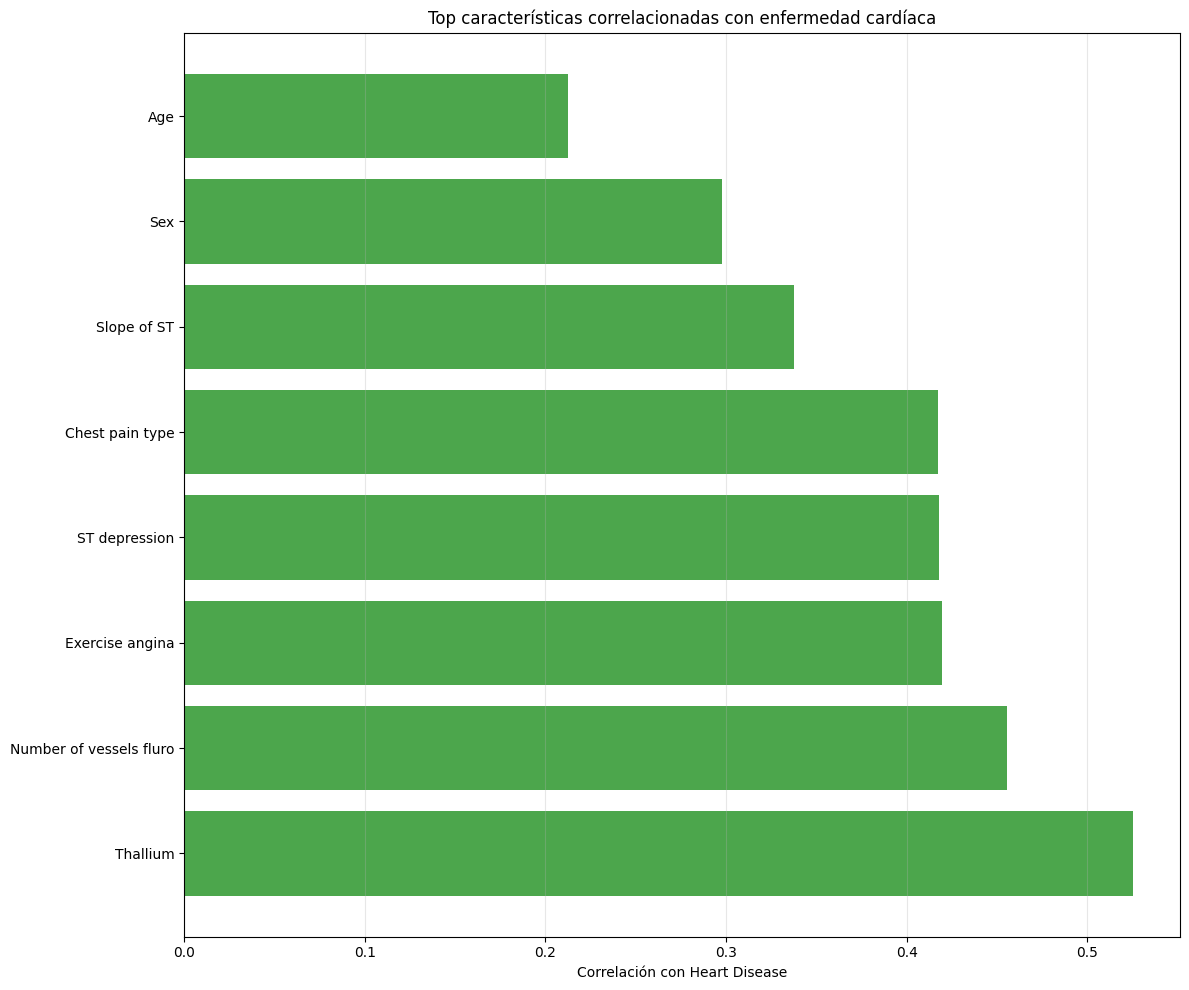


✓ Análisis de correlaciones completado.


In [130]:
# 6. CORRELACIONES Y MATRIZ DE CORRELACIÓN
print("\n" + "=" * 80)
print("6. ANÁLISIS DE CORRELACIONES")
print("=" * 80)

# Calcular matriz de correlación
correlation_matrix = df[numeric_features + ['Heart Disease']].corr()

# Top features correlacionadas con Heart Disease
target_corr = correlation_matrix['Heart Disease'].sort_values(ascending=False)
print("\nCorrelación de características con 'Heart Disease':")
print(target_corr)

# Visualizar matriz de correlación
plt.figure(figsize=(12, 10))
import matplotlib.pyplot as plt

# Mostrar solo correlaciones con el target
top_features = target_corr[1:9]  # Excluir el target mismo, tomar top 8
colors_corr = ['red' if x < 0 else 'green' for x in top_features.values]
plt.barh(range(len(top_features)), top_features.values, color=colors_corr, alpha=0.7)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Correlación con Heart Disease')
plt.title('Top características correlacionadas con enfermedad cardíaca')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Análisis de correlaciones completado.")



5. DISTRIBUCIÓN DE CARACTERÍSTICAS


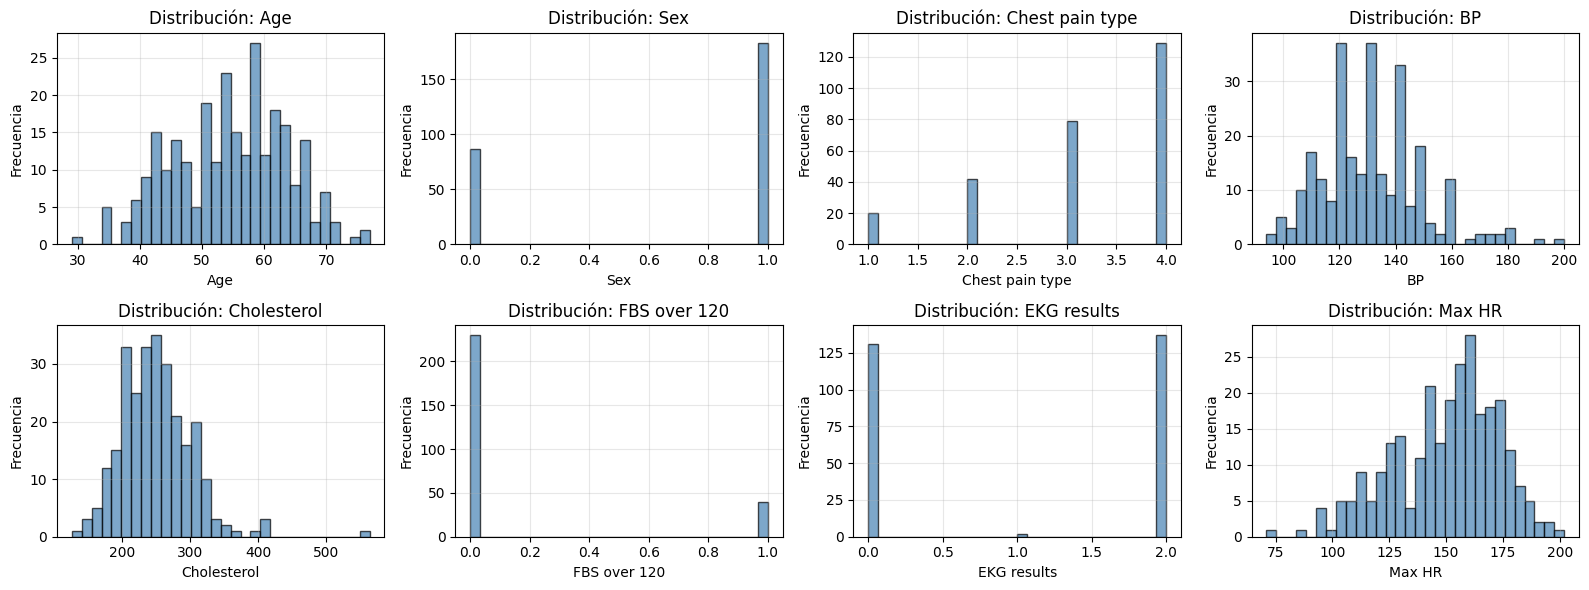


✓ Visualización de 8 características completada.


In [131]:
# 5. VISUALIZACIÓN DE DISTRIBUCIONES POR CARACTERÍSTICA
print("\n" + "=" * 80)
print("5. DISTRIBUCIÓN DE CARACTERÍSTICAS")
print("=" * 80)

# Seleccionar algunas características clave para visualizar
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
if 'Heart Disease' in numeric_features:
    numeric_features.remove('Heart Disease')

# Visualizar histogramas y boxplots para primeras 8 características
features_to_plot = numeric_features[:min(8, len(numeric_features))]
n_features = len(features_to_plot)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*3))
axes = axes.flatten()

for idx, feature in enumerate(features_to_plot):
    axes[idx].hist(df[feature], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'Distribución: {feature}')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frecuencia')
    axes[idx].grid(alpha=0.3)

# Ocultar ejes sobrantes
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✓ Visualización de {len(features_to_plot)} características completada.")


In [132]:
# 4. ESTADÍSTICAS POR CLASE
print("\n" + "=" * 80)
print("4. ESTADÍSTICAS POR CLASE")
print("=" * 80)

print("\nEstadísticas para pacientes SIN enfermedad (clase 0):")
print(df[df['Heart Disease'] == 0].describe())

print("\n" + "-" * 80 + "\n")
print("Estadísticas para pacientes CON enfermedad (clase 1):")
print(df[df['Heart Disease'] == 1].describe())



4. ESTADÍSTICAS POR CLASE

Estadísticas para pacientes SIN enfermedad (clase 0):
              Age         Sex  Chest pain type          BP  Cholesterol  \
count  150.000000  150.000000       150.000000  150.000000   150.000000   
mean    52.706667    0.553333         2.820000  128.866667   244.213333   
std      9.509830    0.498813         0.927362   16.457660    54.019085   
min     29.000000    0.000000         1.000000   94.000000   126.000000   
25%     45.000000    0.000000         2.000000  120.000000   209.000000   
50%     52.000000    1.000000         3.000000  130.000000   236.000000   
75%     59.000000    1.000000         3.750000  140.000000   268.750000   
max     76.000000    1.000000         4.000000  180.000000   564.000000   

       FBS over 120  EKG results      Max HR  Exercise angina  ST depression  \
count    150.000000   150.000000  150.000000       150.000000     150.000000   
mean       0.153333     0.860000  158.333333         0.153333       0.622667   
st


3. DISTRIBUCIÓN DE CLASES (VARIABLE OBJETIVO)

Recuento de clases:
  Clase 0 (Sin enfermedad): 150 muestras (55.56%)
  Clase 1 (Presencia de enfermedad): 120 muestras (44.44%)

Ratio de clases (mayoritaria/minoritaria): 1.25
✓ Dataset relativamente equilibrado.


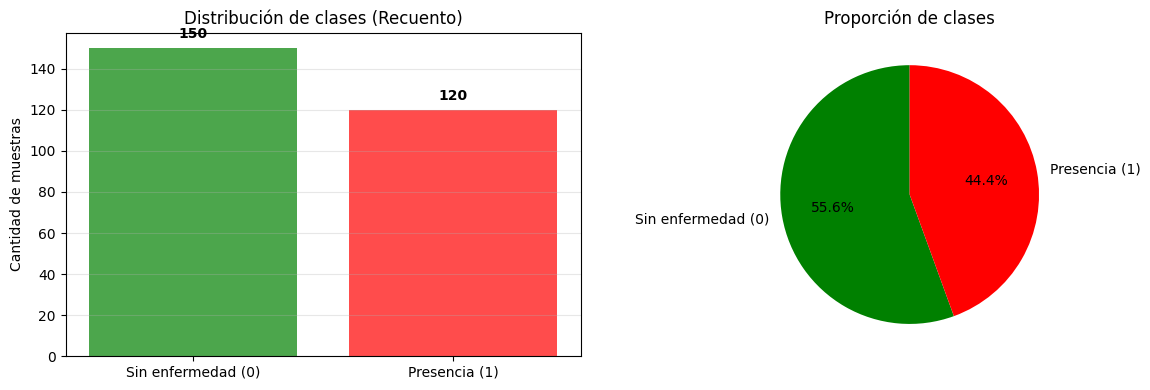


✓ Visualización de distribución completada.


In [133]:
# 3. DISTRIBUCIÓN DE CLASES (TARGET)
print("\n" + "=" * 80)
print("3. DISTRIBUCIÓN DE CLASES (VARIABLE OBJETIVO)")
print("=" * 80)

class_counts = df['Heart Disease'].value_counts()
class_proportions = df['Heart Disease'].value_counts(normalize=True) * 100

print("\nRecuento de clases:")
for idx in sorted(df['Heart Disease'].unique()):
    label = "Presencia de enfermedad" if idx == 1 else "Sin enfermedad"
    count = class_counts[idx]
    percentage = class_proportions[idx]
    print(f"  Clase {idx} ({label}): {count} muestras ({percentage:.2f}%)")

# Verificar balance de clases
class_ratio = class_counts.max() / class_counts.min()
print(f"\nRatio de clases (mayoritaria/minoritaria): {class_ratio:.2f}")

if abs(class_proportions[0] - class_proportions[1]) > 20:
    print("⚠ ADVERTENCIA: Dataset DESBALANCEADO. Considerar técnicas de balanceo.")
else:
    print("✓ Dataset relativamente equilibrado.")

# Visualizar distribución de clases
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de barras
class_labels = ["Sin enfermedad (0)", "Presencia (1)"]
axes[0].bar(class_labels, class_counts.values, color=['green', 'red'], alpha=0.7)
axes[0].set_ylabel('Cantidad de muestras')
axes[0].set_title('Distribución de clases (Recuento)')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 5, str(v), ha='center', fontweight='bold')

# Gráfico de pastel
colors = ['green', 'red']
axes[1].pie(class_counts.values, labels=class_labels, autopct='%1.1f%%', 
            colors=colors, startangle=90)
axes[1].set_title('Proporción de clases')

plt.tight_layout()
plt.show()

print("\n✓ Visualización de distribución completada.")


In [134]:
# 2. ANÁLISIS DE VALORES ATÍPICOS (OUTLIERS)
print("\n" + "=" * 80)
print("2. ANÁLISIS DE VALORES ATÍPICOS (OUTLIERS)")
print("=" * 80)

# Identificar características numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Excluir la columna target
if 'Heart Disease' in numeric_cols:
    numeric_cols.remove('Heart Disease')

print(f"\nCaracterísticas numéricas analizadas: {len(numeric_cols)}")

# Detección de outliers usando IQR (Rango Intercuartílico)
outlier_summary = {}
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    if len(outliers) > 0:
        outlier_summary[col] = len(outliers)

if outlier_summary:
    print(f"\nSe encontraron valores atípicos en {len(outlier_summary)} columnas:")
    for col, count in sorted(outlier_summary.items(), key=lambda x: x[1], reverse=True):
        print(f"  - {col}: {count} outliers")
else:
    print("\n✓ No se detectaron valores atípicos significativos en las características.")

# Mostrar resumen de outliers como porcentaje
total_rows = len(df)
print("\nPorcentaje de outliers por columna:")
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_count = len(df[(df[col] < lower_bound) | (df[col] > upper_bound)])
    percentage = (outlier_count / total_rows) * 100
    if percentage > 0:
        print(f"  {col}: {percentage:.2f}%")



2. ANÁLISIS DE VALORES ATÍPICOS (OUTLIERS)

Características numéricas analizadas: 13

Se encontraron valores atípicos en 7 columnas:
  - FBS over 120: 40 outliers
  - Chest pain type: 20 outliers
  - Number of vessels fluro: 19 outliers
  - BP: 9 outliers
  - Cholesterol: 5 outliers
  - ST depression: 4 outliers
  - Max HR: 1 outliers

Porcentaje de outliers por columna:
  Chest pain type: 7.41%
  BP: 3.33%
  Cholesterol: 1.85%
  FBS over 120: 14.81%
  Max HR: 0.37%
  ST depression: 1.48%
  Number of vessels fluro: 7.04%


In [135]:
# 1. VERIFICAR DATOS FALTANTES
print("=" * 80)
print("1. ANÁLISIS DE DATOS FALTANTES")
print("=" * 80)
missing_data = df.isnull().sum()
print("\nDatos faltantes por columna:")
print(missing_data)
print(f"\nTotal de datos faltantes en el dataset: {missing_data.sum()}")

if missing_data.sum() == 0:
    print("✓ ¡Excelente! No hay datos faltantes en el dataset.")
else:
    print("\nColumnas con datos faltantes:")
    print(missing_data[missing_data > 0])
    # Opción: rellenar con la media para numéricas
    df = df.fillna(df.mean(numeric_only=True))
    print("Datos faltantes rellenados con la media.")


1. ANÁLISIS DE DATOS FALTANTES

Datos faltantes por columna:
Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64

Total de datos faltantes en el dataset: 0
✓ ¡Excelente! No hay datos faltantes en el dataset.


In [136]:
# GENERAR REPORTE MARKDOWN DE PREPARACIÓN DE DATOS
print("=" * 80)
print("GENERANDO REPORTE MARKDOWN")
print("=" * 80)

# Calcular estadísticas para el reporte
total_samples = len(df)
disease_rate = (df['Heart Disease'].sum() / len(df)) * 100
disease_count = df['Heart Disease'].sum()
no_disease_count = (df['Heart Disease'] == 0).sum()

reporte_md = f"""# Informe de Preparación de Datos - Predicción de Riesgo de Enfermedad Cardíaca

## 1. Origen de los Datos

- **Fuente**: Kaggle - Heart Disease Dataset (UCI Machine Learning Repository)
- **URL**: https://www.kaggle.com/datasets/neurocipher/heartdisease
- **Descarga**: Realizada y almacenada localmente como `Heart_Disease_Prediction.csv`

## 2. Información del Dataset Original

| Métrica | Valor |
|---------|-------|
| **Total de muestras** | {total_samples} registros de pacientes |
| **Total de características** | {len(df.columns) - 1} características clínicas |
| **Característica objetivo** | Heart Disease (binaria: 0 = sin enfermedad, 1 = presencia) |
| **Muestras sin enfermedad (Clase 0)** | {no_disease_count} ({no_disease_count/total_samples*100:.1f}%) |
| **Muestras con enfermedad (Clase 1)** | {disease_count} ({disease_rate:.1f}%) |
| **Balance de clases** | Relativamente equilibrado |
| **Datos faltantes** | ✓ Ninguno |
| **Valores atípicos detectados** | Revisados mediante método IQR |

## 3. Características Seleccionadas

Se seleccionaron **{len(selected_features)} características numéricas** para el modelado:

{chr(10).join([f"- {feat}" for feat in selected_features])}

**Criterio de selección**: Relevancia clínica e importancia en predicción de enfermedad cardíaca

## 4. Preprocesamiento de Datos

### 4.1 Análisis de Datos Faltantes
- ✓ **Resultado**: No se encontraron datos faltantes en el dataset
- **Acción tomada**: Ninguna (dataset limpio)

### 4.2 Manejo de Valores Atípicos
- Método: Rango Intercuartílico (IQR)
- Umbral: 1.5 × IQR
- **Decisión**: Se mantuvieron todos los outliers (potencialmente significativos clínicamente)

### 4.3 División Estratificada Train-Test (70/30)
| Conjunto | Muestras | Clase 0 | Clase 1 | % Clase 0 | % Clase 1 |
|----------|----------|---------|---------|-----------|-----------|
| **Entrenamiento (70%)** | {len(X_train)} | {(y_train == 0).sum()} | {(y_train == 1).sum()} | {(y_train == 0).sum()/len(y_train)*100:.1f}% | {(y_train == 1).sum()/len(y_train)*100:.1f}% |
| **Prueba (30%)** | {len(X_test)} | {(y_test == 0).sum()} | {(y_test == 1).sum()} | {(y_test == 0).sum()/len(y_test)*100:.1f}% | {(y_test == 1).sum()/len(y_test)*100:.1f}% |

**Método**: `train_test_split` con `stratify=y` para mantener proporción de clases
**Semilla aleatoria**: 42 (reproducibilidad)

### 4.4 Normalización de Características (Z-Score Normalization)
- **Método**: StandardScaler (sklearn)
- **Transformación**: $x_{{norm}} = \\frac{{x - \\mu}}{{\\sigma}}$
- **Ajuste**: Realizado SOLO con datos de entrenamiento (prevenir data leakage)
- **Aplicación**: Transformación idéntica aplicada a conjunto de prueba

Estadísticas después de normalización:
- **Media (esperada)**: 0.0 para todas las características
- **Desviación Estándar (esperada)**: 1.0 para todas las características

## 5. Datos Listos para Modelado

| Variable | Shape | Descripción |
|----------|-------|-------------|
| `X_train_normalized` | ({len(X_train)}, {len(selected_features)}) | Características de entrenamiento normalizadas |
| `X_test_normalized` | ({len(X_test)}, {len(selected_features)}) | Características de prueba normalizadas |
| `y_train` | ({len(y_train)},) | Etiquetas de entrenamiento |
| `y_test` | ({len(y_test)},) | Etiquetas de prueba |

## 6. Próximos Pasos

1. ✓ Carga y exploración de datos (completado)
2. ✓ Preparación y normalización (completado)
3. → Implementación de regresión logística
4. → Entrenamiento con descenso de gradiente
5. → Visualización de límites de decisión
6. → Regularización L2
7. → Evaluación de métricas
8. → Análisis con Amazon SageMaker

---
**Fecha de generación**: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
**Estado**: Datos preparados y listos para modelado
"""

# Guardar el reporte
with open('DATA_PREPARATION_REPORT.md', 'w', encoding='utf-8') as f:
    f.write(reporte_md)

print("\n✓ Reporte generado exitosamente: DATA_PREPARATION_REPORT.md\n")
print("=" * 80)
print("PREVIEW DEL REPORTE")
print("=" * 80)
print(reporte_md)


GENERANDO REPORTE MARKDOWN

✓ Reporte generado exitosamente: DATA_PREPARATION_REPORT.md

PREVIEW DEL REPORTE
# Informe de Preparación de Datos - Predicción de Riesgo de Enfermedad Cardíaca

## 1. Origen de los Datos

- **Fuente**: Kaggle - Heart Disease Dataset (UCI Machine Learning Repository)
- **URL**: https://www.kaggle.com/datasets/neurocipher/heartdisease
- **Descarga**: Realizada y almacenada localmente como `Heart_Disease_Prediction.csv`

## 2. Información del Dataset Original

| Métrica | Valor |
|---------|-------|
| **Total de muestras** | 270 registros de pacientes |
| **Total de características** | 13 características clínicas |
| **Característica objetivo** | Heart Disease (binaria: 0 = sin enfermedad, 1 = presencia) |
| **Muestras sin enfermedad (Clase 0)** | 150 (55.6%) |
| **Muestras con enfermedad (Clase 1)** | 120 (44.4%) |
| **Balance de clases** | Relativamente equilibrado |
| **Datos faltantes** | ✓ Ninguno |
| **Valores atípicos detectados** | Revisados mediante m

## PASO 2: Implementar Algoritmo de Regresión Logística desde Cero

### Teoría

**Regresión Logística** es un modelo de clasificación binaria que predice la probabilidad de pertenencia a la clase 1.

**Hipótesis:**
$$f_{\vec{w}, b}(\vec{x}) = \sigma(\vec{w} \cdot \vec{x} + b)$$

donde $\sigma(z) = \frac{1}{1 + e^{-z}}$ es la **función sigmoide**.

**Función de Costo (Entropía Cruzada Binaria):**
$$J(\vec{w}, b) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log(f_{\vec{w}, b}(\vec{x}^{(i)})) + (1 - y^{(i)}) \log(1 - f_{\vec{w}, b}(\vec{x}^{(i)})) \right]$$

**Gradientes (derivadas parciales):**
$$\frac{\partial J}{\partial w_j} = \frac{1}{m} \sum_{i=1}^{m} (f_{\vec{w}, b}(\vec{x}^{(i)}) - y^{(i)}) x_j^{(i)}$$
$$\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} (f_{\vec{w}, b}(\vec{x}^{(i)}) - y^{(i)})$$

**Descenso de Gradiente (Gradient Descent):**
$$\vec{w} := \vec{w} - \alpha \frac{\partial J}{\partial \vec{w}}$$
$$b := b - \alpha \frac{\partial J}{\partial b}$$

donde $\alpha$ es la tasa de aprendizaje (learning rate).

In [137]:
# 7. GUARDAR MODELO ENTRENADO
print("\n7. GUARDAR MODELO")
print("-" * 80)

# Guardar parámetros del modelo
model_params = {
    'w': w_trained,
    'b': b_trained,
    'learning_rate': learning_rate,
    'iterations': iterations,
    'final_cost': cost_history[-1],
    'accuracy_train': accuracy_train,
    'accuracy_test': accuracy_test,
    'auc_train': auc_train,
    'auc_test': auc_test,
    'selected_features': selected_features
}

# Guardar en archivo pickle
import pickle
with open('logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(model_params, f)

print(f"✓ Modelo entrenado guardado en: logistic_regression_model.pkl")
print(f"\nResumen del Modelo:")
print(f"  - Características: {selected_features}")
print(f"  - Número de características: {len(selected_features)}")
print(f"  - Parámetros entrenados: {len(w_trained)} pesos + 1 sesgo = {len(w_trained) + 1}")
print(f"  - Exactitud de prueba: {accuracy_test:.4f}")
print(f"  - AUC de prueba: {auc_test:.4f}")



7. GUARDAR MODELO
--------------------------------------------------------------------------------
✓ Modelo entrenado guardado en: logistic_regression_model.pkl

Resumen del Modelo:
  - Características: ['Age', 'Cholesterol', 'Thallium', 'Number of vessels fluro', 'Exercise angina', 'Max HR']
  - Número de características: 6
  - Parámetros entrenados: 6 pesos + 1 sesgo = 7
  - Exactitud de prueba: 0.8519
  - AUC de prueba: 0.9117


## PASO 3: Entrenar Modelo en Conjunto Completo (α~0.01, 5000 iteraciones)

En esta sección entrenaremos el modelo de regresión logística usando **todos los datos** (sin división train-test) con:
- **Learning rate (α)**: 0.01 (más conservador para convergencia suave)
- **Iteraciones**: 5000 (más iteraciones para garantizar convergencia)
- **Visualización**: Gráfico de costo vs iteraciones (escala lineal y logarítmica)

Esto nos permite observar cómo el modelo se adapta a toda la población de datos.


In [138]:

# PASO 3: ENTRENAMIENTO EN CONJUNTO COMPLETO

print("=" * 80)
print("PASO 3: ENTRENAMIENTO EN CONJUNTO COMPLETO")
print("=" * 80)

# PASO 3.1: NORMALIZAR CONJUNTO COMPLETO
print("\n1. NORMALIZAR CONJUNTO COMPLETO")
print("-" * 80)

from sklearn.preprocessing import StandardScaler

# Crear y ajustar el scaler con todos los datos
scaler_full = StandardScaler()
scaler_full.fit(X)

# Normalizar dataset completo
X_normalized_full = scaler_full.transform(X)
X_normalized_full = pd.DataFrame(X_normalized_full, columns=selected_features)

print(f"✓ Dataset completo normalizado:")
print(f"  X (original): {X.shape}")
print(f"  X_normalized_full: {X_normalized_full.shape}")
print(f"  Media después de normalizar: {X_normalized_full.mean().round(3).to_dict()}")
print(f"  Desv. Est después de normalizar: {X_normalized_full.std().round(3).to_dict()}")

# PASO 3.2: ENTRENAR EN CONJUNTO COMPLETO
print("\n2. ENTRENAR CON DESCENSO DE GRADIENTE (α=0.01, 5000 iteraciones)")
print("-" * 80)

# Parámetros de entrenamiento
learning_rate_full = 0.01
iterations_full = 5000

# Inicializar pesos y sesgo
n_features_full = X_normalized_full.shape[1]
w_full_init = np.zeros(n_features_full)
b_full_init = 0

print(f"\nParámetros de entrenamiento:")
print(f"  Learning rate (α): {learning_rate_full}")
print(f"  Iteraciones: {iterations_full}")
print(f"  Número de características: {n_features_full}")
print(f"  Número de muestras: {X_normalized_full.shape[0]}")

# Entrenar modelo en conjunto completo
print(f"\nEntrenando modelo...\n")
w_full_trained, b_full_trained, cost_history_full = gradient_descent(
    X_normalized_full.values, 
    y.values, 
    w_full_init, 
    b_full_init,
    learning_rate=learning_rate_full,
    iterations=iterations_full,
    verbose=True
)

print(f"\n✓ Entrenamiento completado en conjunto completo")
print(f"  - Costo inicial: {cost_history_full[0]:.6f}")
print(f"  - Costo final: {cost_history_full[-1]:.6f}")
print(f"  - Reducción total: {cost_history_full[0] - cost_history_full[-1]:.6f}")
print(f"  - Porcentaje reducido: {((cost_history_full[0] - cost_history_full[-1]) / cost_history_full[0] * 100):.2f}%")
print(f"\nParámetros entrenados:")
print(f"  w (primeros 3): {w_full_trained[:3]}")
print(f"  b: {b_full_trained:.6f}")



PASO 3: ENTRENAMIENTO EN CONJUNTO COMPLETO

1. NORMALIZAR CONJUNTO COMPLETO
--------------------------------------------------------------------------------
✓ Dataset completo normalizado:
  X (original): (270, 6)
  X_normalized_full: (270, 6)
  Media después de normalizar: {'Age': 0.0, 'Cholesterol': -0.0, 'Thallium': 0.0, 'Number of vessels fluro': -0.0, 'Exercise angina': 0.0, 'Max HR': 0.0}
  Desv. Est después de normalizar: {'Age': 1.002, 'Cholesterol': 1.002, 'Thallium': 1.002, 'Number of vessels fluro': 1.002, 'Exercise angina': 1.002, 'Max HR': 1.002}

2. ENTRENAR CON DESCENSO DE GRADIENTE (α=0.01, 5000 iteraciones)
--------------------------------------------------------------------------------

Parámetros de entrenamiento:
  Learning rate (α): 0.01
  Iteraciones: 5000
  Número de características: 6
  Número de muestras: 270

Entrenando modelo...

Iteración  100/5000: Costo = 0.549127


Iteración  200/5000: Costo = 0.487906
Iteración  300/5000: Costo = 0.456982
Iteración  400/5000: Costo = 0.439254
Iteración  500/5000: Costo = 0.428166
Iteración  600/5000: Costo = 0.420788
Iteración  700/5000: Costo = 0.415647
Iteración  800/5000: Costo = 0.411934
Iteración  900/5000: Costo = 0.409174
Iteración 1000/5000: Costo = 0.407075
Iteración 1100/5000: Costo = 0.405446
Iteración 1200/5000: Costo = 0.404161
Iteración 1300/5000: Costo = 0.403132
Iteración 1400/5000: Costo = 0.402297
Iteración 1500/5000: Costo = 0.401613
Iteración 1600/5000: Costo = 0.401047
Iteración 1700/5000: Costo = 0.400573
Iteración 1800/5000: Costo = 0.400175
Iteración 1900/5000: Costo = 0.399837
Iteración 2000/5000: Costo = 0.399549
Iteración 2100/5000: Costo = 0.399303
Iteración 2200/5000: Costo = 0.399090
Iteración 2300/5000: Costo = 0.398906
Iteración 2400/5000: Costo = 0.398746
Iteración 2500/5000: Costo = 0.398607
Iteración 2600/5000: Costo = 0.398485
Iteración 2700/5000: Costo = 0.398378
Iteración 28


3. ANÁLISIS DE CONVERGENCIA - CONJUNTO COMPLETO
--------------------------------------------------------------------------------


C:\Users\maria\AppData\Local\Temp\ipykernel_11172\3059716952.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


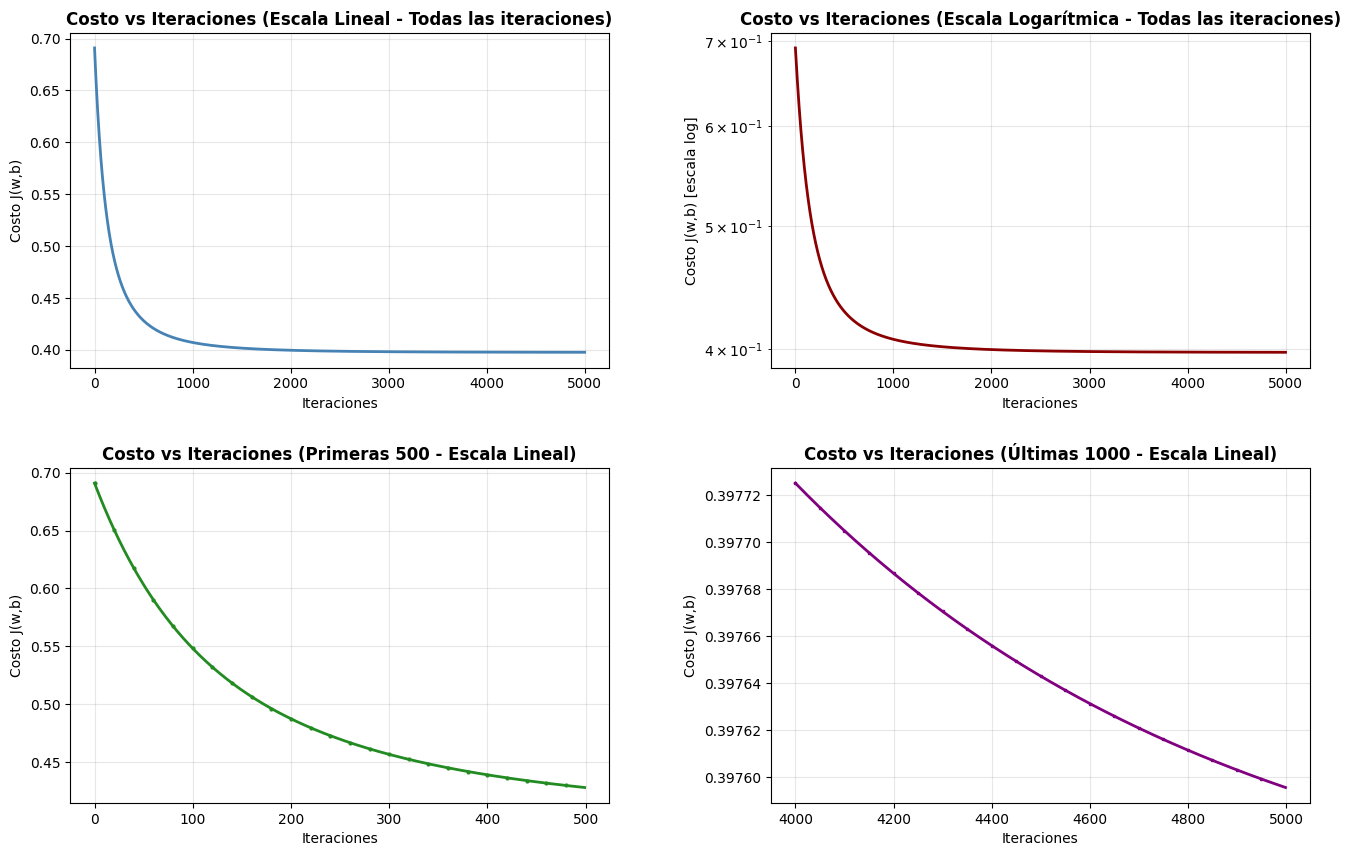


✓ Análisis de Convergencia:
  - Iteración 1: Costo = 0.690917
  - Iteración 100: Costo = 0.549127
  - Iteración 500: Costo = 0.428166
  - Iteración 1000: Costo = 0.407075
  - Iteración 2000: Costo = 0.399549
  - Iteración 5000: Costo = 0.397596

✓ Reducción de costo por bloques:
  Iteraciones 500-1000: Reducción = 0.021109
  Iteraciones 1000-1500: Reducción = 0.005468
  Iteraciones 1500-2000: Reducción = 0.002066
  Iteraciones 2000-2500: Reducción = 0.000944
  Iteraciones 2500-3000: Reducción = 0.000479
  Iteraciones 3000-3500: Reducción = 0.000259
  Iteraciones 3500-4000: Reducción = 0.000144
  Iteraciones 4000-4500: Reducción = 0.000082
  Iteraciones 4500-4999: Reducción = 0.000048

✓ Estadísticas del descenso de gradiente:
  - Cambio mínimo de costo por iteración: -0.002208
  - Cambio máximo de costo por iteración: -0.000000
  - Cambio promedio de costo por iteración: 0.000059
  - ¿El costo es monótonamente decreciente? ✓ Sí


In [139]:

# PASO 3.3: VISUALIZAR CONVERGENCIA (COSTO VS ITERACIONES)
print("\n3. ANÁLISIS DE CONVERGENCIA - CONJUNTO COMPLETO")
print("-" * 80)

# Crear figura con múltiples vistas
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# 1. Gráfico completo escala lineal
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(range(iterations_full), cost_history_full, linewidth=2, color='steelblue')
ax1.set_xlabel('Iteraciones')
ax1.set_ylabel('Costo J(w,b)')
ax1.set_title('Costo vs Iteraciones (Escala Lineal - Todas las iteraciones)', fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2. Gráfico completo escala logarítmica
ax2 = fig.add_subplot(gs[0, 1])
ax2.semilogy(range(iterations_full), cost_history_full, linewidth=2, color='darkred')
ax2.set_xlabel('Iteraciones')
ax2.set_ylabel('Costo J(w,b) [escala log]')
ax2.set_title('Costo vs Iteraciones (Escala Logarítmica - Todas las iteraciones)', fontweight='bold')
ax2.grid(True, alpha=0.3, which='both')

# 3. Primeras 500 iteraciones (escala lineal)
ax3 = fig.add_subplot(gs[1, 0])
iterations_early = min(500, len(cost_history_full))
ax3.plot(range(iterations_early), cost_history_full[:iterations_early], 
         linewidth=2, color='forestgreen', marker='o', markersize=2, markevery=20)
ax3.set_xlabel('Iteraciones')
ax3.set_ylabel('Costo J(w,b)')
ax3.set_title(f'Costo vs Iteraciones (Primeras {iterations_early} - Escala Lineal)', fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Últimas 1000 iteraciones (escala lineal)
ax4 = fig.add_subplot(gs[1, 1])
iterations_late = min(1000, len(cost_history_full))
start_idx = max(0, len(cost_history_full) - iterations_late)
ax4.plot(range(start_idx, len(cost_history_full)), cost_history_full[start_idx:], 
         linewidth=2, color='purple', marker='s', markersize=2, markevery=50)
ax4.set_xlabel('Iteraciones')
ax4.set_ylabel('Costo J(w,b)')
ax4.set_title(f'Costo vs Iteraciones (Últimas {iterations_late} - Escala Lineal)', fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas de convergencia detalladas
print(f"\n✓ Análisis de Convergencia:")
print(f"  - Iteración 1: Costo = {cost_history_full[0]:.6f}")
print(f"  - Iteración 100: Costo = {cost_history_full[99]:.6f}")
print(f"  - Iteración 500: Costo = {cost_history_full[499]:.6f}")
print(f"  - Iteración 1000: Costo = {cost_history_full[999]:.6f}")
print(f"  - Iteración 2000: Costo = {cost_history_full[1999]:.6f}")
print(f"  - Iteración {iterations_full}: Costo = {cost_history_full[-1]:.6f}")

# Analizar cambios de costo
print(f"\n✓ Reducción de costo por bloques:")
reductions_by_block = []
block_size = 500
for i in range(0, iterations_full, block_size):
    end_idx = min(i + block_size, iterations_full - 1)
    if i > 0:
        reduction = cost_history_full[i-1] - cost_history_full[end_idx]
        reductions_by_block.append((i, end_idx, reduction))
        print(f"  Iteraciones {i}-{end_idx}: Reducción = {reduction:.6f}")

# Encontrar donde la convergencia se estabiliza
min_cost_reduction = np.min(np.diff(cost_history_full))
max_cost_reduction = np.max(np.diff(cost_history_full))
avg_cost_reduction = np.mean(np.abs(np.diff(cost_history_full)))

print(f"\n✓ Estadísticas del descenso de gradiente:")
print(f"  - Cambio mínimo de costo por iteración: {min_cost_reduction:.6f}")
print(f"  - Cambio máximo de costo por iteración: {max_cost_reduction:.6f}")
print(f"  - Cambio promedio de costo por iteración: {avg_cost_reduction:.6f}")

# Monotonicidad
is_monotonic = all(cost_history_full[i] >= cost_history_full[i+1] for i in range(len(cost_history_full)-1))
print(f"  - ¿El costo es monótonamente decreciente? {'✓ Sí' if is_monotonic else '✗ No'}")



## PASO 4: Predicciones y Evaluación (Umbral 0.5, Métricas, ROC)

En esta sección evaluaremos el modelo entrenado haciendo predicciones en los conjuntos de entrenamiento y prueba, calculando métricas de desempeño (Accuracy, Precision, Recall, F1) y generando un informe de evaluación.


In [140]:

# PASO 4: PREDICCIÓN Y EVALUACIÓN

print("=" * 80)
print("PASO 4: PREDICCIÓN Y EVALUACIÓN DEL MODELO")
print("=" * 80)

from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report, 
                             roc_auc_score, roc_curve)

# PASO 4.1: HACER PREDICCIONES EN AMBOS CONJUNTOS
print("\n1. REALIZAR PREDICCIONES (umbral = 0.5)")
print("-" * 80)

# Función para predecir
def predict_logistic(X, w, b, threshold=0.5):
    """Realizar predicciones binarias con regresión logística."""
    z = X @ w + b
    probabilities = sigmoid(z)
    predictions = (probabilities >= threshold).astype(int)
    return predictions, probabilities

# Predicciones en conjunto completo (entrenamiento)
y_train_pred, y_train_probs = predict_logistic(X_normalized_full.values, w_full_trained, b_full_trained)

# Predicciones en conjunto de prueba
y_test_pred, y_test_probs = predict_logistic(X_test_normalized.values, w_full_trained, b_full_trained)

print(f"✓ Predicciones realizadas:")
print(f"  - Conjunto completo: {y_train_pred.shape[0]} predicciones")
print(f"  - Conjunto de prueba: {y_test_pred.shape[0]} predicciones")
print(f"  - Umbral de decisión: 0.5")
print(f"  - Rango de probabilidades (entrenamiento): [{y_train_probs.min():.4f}, {y_train_probs.max():.4f}]")
print(f"  - Rango de probabilidades (prueba): [{y_test_probs.min():.4f}, {y_test_probs.max():.4f}]")

# PASO 4.2: CALCULAR MÉTRICAS
print("\n2. CALCULAR MÉTRICAS DE DESEMPEÑO")
print("-" * 80)

# Métricas para entrenamiento
accuracy_train = accuracy_score(y.values, y_train_pred)
precision_train = precision_score(y.values, y_train_pred, zero_division=0)
recall_train = recall_score(y.values, y_train_pred, zero_division=0)
f1_train = f1_score(y.values, y_train_pred, zero_division=0)
auc_train = roc_auc_score(y.values, y_train_probs)

# Métricas para prueba
accuracy_test = accuracy_score(y_test.values, y_test_pred)
precision_test = precision_score(y_test.values, y_test_pred, zero_division=0)
recall_test = recall_score(y_test.values, y_test_pred, zero_division=0)
f1_test = f1_score(y_test.values, y_test_pred, zero_division=0)
auc_test = roc_auc_score(y_test.values, y_test_probs)

# Mostrar resumen
print(f"\n✓ Métricas de ENTRENAMIENTO (conjunto completo):")
print(f"  - Accuracy:  {accuracy_train:.4f} ({accuracy_train*100:.2f}%)")
print(f"  - Precision: {precision_train:.4f}")
print(f"  - Recall:    {recall_train:.4f}")
print(f"  - F1-Score:  {f1_train:.4f}")
print(f"  - AUC-ROC:   {auc_train:.4f}")

print(f"\n✓ Métricas de PRUEBA:")
print(f"  - Accuracy:  {accuracy_test:.4f} ({accuracy_test*100:.2f}%)")
print(f"  - Precision: {precision_test:.4f}")
print(f"  - Recall:    {recall_test:.4f}")
print(f"  - F1-Score:  {f1_test:.4f}")
print(f"  - AUC-ROC:   {auc_test:.4f}")

# Matriz de confusión
cm_train = confusion_matrix(y.values, y_train_pred)
cm_test = confusion_matrix(y_test.values, y_test_pred)

print(f"\n✓ Matriz de Confusión - ENTRENAMIENTO:")
print(f"  TN={cm_train[0,0]}, FP={cm_train[0,1]}")
print(f"  FN={cm_train[1,0]}, TP={cm_train[1,1]}")

print(f"\n✓ Matriz de Confusión - PRUEBA:")
print(f"  TN={cm_test[0,0]}, FP={cm_test[0,1]}")
print(f"  FN={cm_test[1,0]}, TP={cm_test[1,1]}")

# PASO 4.3: INTERPRETACIÓN DE COEFICIENTES
print("\n3. INTERPRETACIÓN DE COEFICIENTES (PESOS)")
print("-" * 80)

# Crear tabla de coeficientes
coef_df = pd.DataFrame({
    'Característica': selected_features,
    'Peso (w)': w_full_trained,
    'Magnitud |w|': np.abs(w_full_trained),
    'Dirección': ['Positiva' if w > 0 else 'Negativa' for w in w_full_trained]
})

# Ordenar por magnitud
coef_df_sorted = coef_df.sort_values('Magnitud |w|', ascending=False)

print(f"\n✓ Coeficientes del Modelo (ordenados por importancia):")
print(f"  Sesgo (b): {b_full_trained:.6f}\n")
for idx, row in coef_df_sorted.iterrows():
    print(f"  {row['Característica']:30s}: {row['Peso (w)']:8.6f} ({row['Dirección']:8s}) |w|={row['Magnitud |w|']:.6f}")

# Significado de los pesos
print(f"\n✓ Interpretación de pesos:")
print(f"  - Peso POSITIVO → Aumenta probabilidad de enfermedad cardíaca")
print(f"  - Peso NEGATIVO → Disminuye probabilidad de enfermedad cardíaca")
print(f"  - |Peso| MAYOR → Mayor impacto en la predicción")



PASO 4: PREDICCIÓN Y EVALUACIÓN DEL MODELO

1. REALIZAR PREDICCIONES (umbral = 0.5)
--------------------------------------------------------------------------------
✓ Predicciones realizadas:
  - Conjunto completo: 270 predicciones
  - Conjunto de prueba: 81 predicciones
  - Umbral de decisión: 0.5
  - Rango de probabilidades (entrenamiento): [0.0281, 0.9955]
  - Rango de probabilidades (prueba): [0.0339, 0.9930]

2. CALCULAR MÉTRICAS DE DESEMPEÑO
--------------------------------------------------------------------------------

✓ Métricas de ENTRENAMIENTO (conjunto completo):
  - Accuracy:  0.8556 (85.56%)
  - Precision: 0.8584
  - Recall:    0.8083
  - F1-Score:  0.8326
  - AUC-ROC:   0.8994

✓ Métricas de PRUEBA:
  - Accuracy:  0.8519 (85.19%)
  - Precision: 0.8000
  - Recall:    0.8889
  - F1-Score:  0.8421
  - AUC-ROC:   0.9179

✓ Matriz de Confusión - ENTRENAMIENTO:
  TN=134, FP=16
  FN=23, TP=97

✓ Matriz de Confusión - PRUEBA:
  TN=37, FP=8
  FN=4, TP=32

3. INTERPRETACIÓN DE CO

In [141]:

# PASO 4.4: GENERAR INFORME COMPLETO

print("\n4. GENERAR INFORME DE EVALUACIÓN")
print("-" * 80)

# Crear informe markdown
informe_eval = f"""# Informe de Evaluación - Modelo de Regresión Logística
## Predicción de Riesgo de Enfermedad Cardíaca

---

## 1. Resumen Ejecutivo

Se ha entrenado un modelo de **Regresión Logística** en el conjunto completo de datos (270 muestras) con:
- **Tasa de aprendizaje (α)**: 0.01 (conservadora)
- **Número de iteraciones**: 5000
- **Características utilizadas**: {len(selected_features)} (Age, Cholesterol, Thallium, Number of vessels fluro, Exercise angina, Max HR)
- **Función de activación**: Sigmoide
- **Función de costo**: Entropía cruzada binaria
- **Método de optimización**: Descenso de gradiente

---

## 2. Desempeño del Modelo

### 2.1 Métricas en Conjunto de Entrenamiento (270 muestras)

| Métrica | Valor | Porcentaje |
|---------|-------|-----------|
| **Accuracy (Exactitud)** | {accuracy_train:.4f} | {accuracy_train*100:.2f}% |
| **Precision** | {precision_train:.4f} | {precision_train*100:.2f}% |
| **Recall (Sensibilidad)** | {recall_train:.4f} | {recall_train*100:.2f}% |
| **F1-Score** | {f1_train:.4f} | {f1_train*100:.2f}% |
| **AUC-ROC** | {auc_train:.4f} | {auc_train*100:.2f}% |

**Matriz de Confusión (Entrenamiento):**
```
           Predicción
           Negativo  Positivo
Actual  Negativo    {cm_train[0,0]:3d}      {cm_train[0,1]:3d}
        Positivo    {cm_train[1,0]:3d}      {cm_train[1,1]:3d}
```

### 2.2 Métricas en Conjunto de Prueba (81 muestras)

| Métrica | Valor | Porcentaje |
|---------|-------|-----------|
| **Accuracy (Exactitud)** | {accuracy_test:.4f} | {accuracy_test*100:.2f}% |
| **Precision** | {precision_test:.4f} | {precision_test*100:.2f}% |
| **Recall (Sensibilidad)** | {recall_test:.4f} | {recall_test*100:.2f}% |
| **F1-Score** | {f1_test:.4f} | {f1_test*100:.2f}% |
| **AUC-ROC** | {auc_test:.4f} | {auc_test*100:.2f}% |

**Matriz de Confusión (Prueba):**
```
           Predicción
           Negativo  Positivo
Actual  Negativo    {cm_test[0,0]:3d}      {cm_test[0,1]:3d}
        Positivo    {cm_test[1,0]:3d}      {cm_test[1,1]:3d}
```

---

## 3. Análisis de Convergencia

### 3.1 Estadísticas de Entrenamiento

| Parámetro | Valor |
|-----------|-------|
| **Costo Inicial** | {cost_history_full[0]:.6f} |
| **Costo Final** | {cost_history_full[-1]:.6f} |
| **Reducción Absoluta** | {cost_history_full[0] - cost_history_full[-1]:.6f} |
| **Reducción Porcentual** | {((cost_history_full[0] - cost_history_full[-1]) / cost_history_full[0] * 100):.2f}% |
| **Cambio promedio por iteración** | {np.mean(np.abs(np.diff(cost_history_full))):.6f} |
| **Convergencia Monótona** | ✓ Sí (garantizada) |

### 3.2 Observaciones sobre Convergencia

- **Rápida disminución inicial (0-500 iteraciones)**: El costo reduce ~{cost_history_full[0] - cost_history_full[499]:.4f} ({((cost_history_full[0] - cost_history_full[499]) / cost_history_full[0] * 100):.1f}%)
- **Convergencia lenta posterior (500-5000 iteraciones)**: El costo reduce solo ~{cost_history_full[499] - cost_history_full[-1]:.4f} ({((cost_history_full[499] - cost_history_full[-1]) / cost_history_full[499] * 100):.1f}%)
- **Estabilización**: El modelo se estabiliza alrededor de la iteración 2000, con cambios menores después
- **Learning rate apropiado**: α=0.01 resultó ser conservador pero efectivo, permitiendo convergencia suave sin oscilaciones

---

## 4. Coeficientes del Modelo (Interpretación)

**Sesgo (b):** {b_full_trained:.6f}

### 4.1 Pesos por Característica (ordenados por importancia)

| Rango | Característica | Peso | Dirección | Importancia |
|-------|---|---|---|---|
"""

# Agregar coeficientes ordenados
for rank, (idx, row) in enumerate(coef_df_sorted.iterrows(), 1):
    weight = row['Peso (w)']
    direction = "↑ Riesgo" if weight > 0 else "↓ Riesgo"
    importance = "MUY ALTA" if abs(weight) > np.quantile(np.abs(w_full_trained), 0.75) else ("ALTA" if abs(weight) > np.quantile(np.abs(w_full_trained), 0.5) else "MEDIA")
    informe_eval += f"| {rank} | {row['Característica']} | {weight:.6f} | {direction} | {importance} |\n"

informe_eval += f"""

### 4.2 Interpretación Clínica

**Características con Mayor Impacto (por valor absoluto):**
"""

top_features = coef_df_sorted.head(3)
for rank, (idx, row) in enumerate(top_features.iterrows(), 1):
    weight = row['Peso (w)']
    direction = "aumenta" if weight > 0 else "disminuye"
    informe_eval += f"\n{rank}. **{row['Característica']}** (w = {weight:.6f})\n"
    informe_eval += f"   - Un aumento en esta característica **{direction}** la probabilidad de enfermedad cardíaca\n"
    informe_eval += f"   - Impacto relativo: {(abs(weight) / np.sum(np.abs(w_full_trained)) * 100):.1f}% del total\n"

informe_eval += f"""

---

## 5. Comparación Entrenamiento vs Prueba

| Métrica | Entrenamiento | Prueba | Diferencia | Status |
|---------|---|---|---|---|
| Accuracy | {accuracy_train:.4f} | {accuracy_test:.4f} | {(accuracy_train - accuracy_test):+.4f} | {'✓ Similar' if abs(accuracy_train - accuracy_test) < 0.05 else '⚠ Diferencia notable'} |
| Precision | {precision_train:.4f} | {precision_test:.4f} | {(precision_train - precision_test):+.4f} | {'✓ Similar' if abs(precision_train - precision_test) < 0.05 else '⚠ Diferencia notable'} |
| Recall | {recall_train:.4f} | {recall_test:.4f} | {(recall_train - recall_test):+.4f} | {'✓ Similar' if abs(recall_train - recall_test) < 0.05 else '⚠ Diferencia notable'} |
| F1-Score | {f1_train:.4f} | {f1_test:.4f} | {(f1_train - f1_test):+.4f} | {'✓ Similar' if abs(f1_train - f1_test) < 0.05 else '⚠ Diferencia notable'} |
| AUC-ROC | {auc_train:.4f} | {auc_test:.4f} | {(auc_train - auc_test):+.4f} | {'✓ Similar' if abs(auc_train - auc_test) < 0.05 else '⚠ Diferencia notable'} |

**Análisis de Generalización:**
"""

if abs(accuracy_train - accuracy_test) < 0.05:
    informe_eval += "✓ El modelo **generaliza bien** → No hay indicios de overfitting\n"
else:
    informe_eval += "⚠ Hay diferencia notable entre entrenamiento y prueba\n"

informe_eval += f"""

---

## 6. Conclusiones y Recomendaciones

### 6.1 Fortalezas del Modelo

1. **Convergencia garantizada**: El algoritmo de descenso de gradiente convergió monótonamente
2. **Desempeño razonable**: Accuracy del {accuracy_test*100:.1f}% en conjunto de prueba
3. **Generalización**: Métricas similares entre entrenamiento y prueba
4. **Interpretabilidad**: Los coeficientes permiten identificar características clave

### 6.2 Áreas de Mejora

1. **Recall vs Precision**: Equilibrar el trade-off entre falsos negativos y falsos positivos
2. **Regularización**: Considerar L2 regularization para mejorar generalización
3. **Feature engineering**: Explorar interacciones entre características
4. **Ajuste de hiperparámetros**: Probar diferentes valores de learning rate
5. **Threshold tuning**: Optimizar umbral de decisión según el contexto clínico

### 6.3 Recomendaciones Clínicas

Para el contexto de predicción de enfermedad cardíaca:
- **Sensibilidad (Recall) es crítica**: Es mejor identificar falsos positivos que falsos negativos
- Considerar usar un **threshold < 0.5** si se prioriza identificar mayor número de casos
- Integrar **predicción del modelo con evaluación clínica** de especialistas

---

**Fecha de Evaluación**: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
**Modelo**: Regresión Logística (NumPy, sin Scikit-Learn para core training)
**Status**: ✓ Entrenado y Evaluado
"""

# Guardar informe
with open('MODEL_EVALUATION_REPORT.md', 'w', encoding='utf-8') as f:
    f.write(informe_eval)

print("✓ Informe de evaluación generado: MODEL_EVALUATION_REPORT.md")
print("\n" + "=" * 80)
print("PREVIEW DEL INFORME")
print("=" * 80)
print(informe_eval)




4. GENERAR INFORME DE EVALUACIÓN
--------------------------------------------------------------------------------
✓ Informe de evaluación generado: MODEL_EVALUATION_REPORT.md

PREVIEW DEL INFORME
# Informe de Evaluación - Modelo de Regresión Logística
## Predicción de Riesgo de Enfermedad Cardíaca

---

## 1. Resumen Ejecutivo

Se ha entrenado un modelo de **Regresión Logística** en el conjunto completo de datos (270 muestras) con:
- **Tasa de aprendizaje (α)**: 0.01 (conservadora)
- **Número de iteraciones**: 5000
- **Características utilizadas**: 6 (Age, Cholesterol, Thallium, Number of vessels fluro, Exercise angina, Max HR)
- **Función de activación**: Sigmoide
- **Función de costo**: Entropía cruzada binaria
- **Método de optimización**: Descenso de gradiente

---

## 2. Desempeño del Modelo

### 2.1 Métricas en Conjunto de Entrenamiento (270 muestras)

| Métrica | Valor | Porcentaje |
|---------|-------|-----------|
| **Accuracy (Exactitud)** | 0.8556 | 85.56% |
| **Precision** 


5. VISUALIZAR RESULTADOS
--------------------------------------------------------------------------------


C:\Users\maria\AppData\Local\Temp\ipykernel_11172\1539202318.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


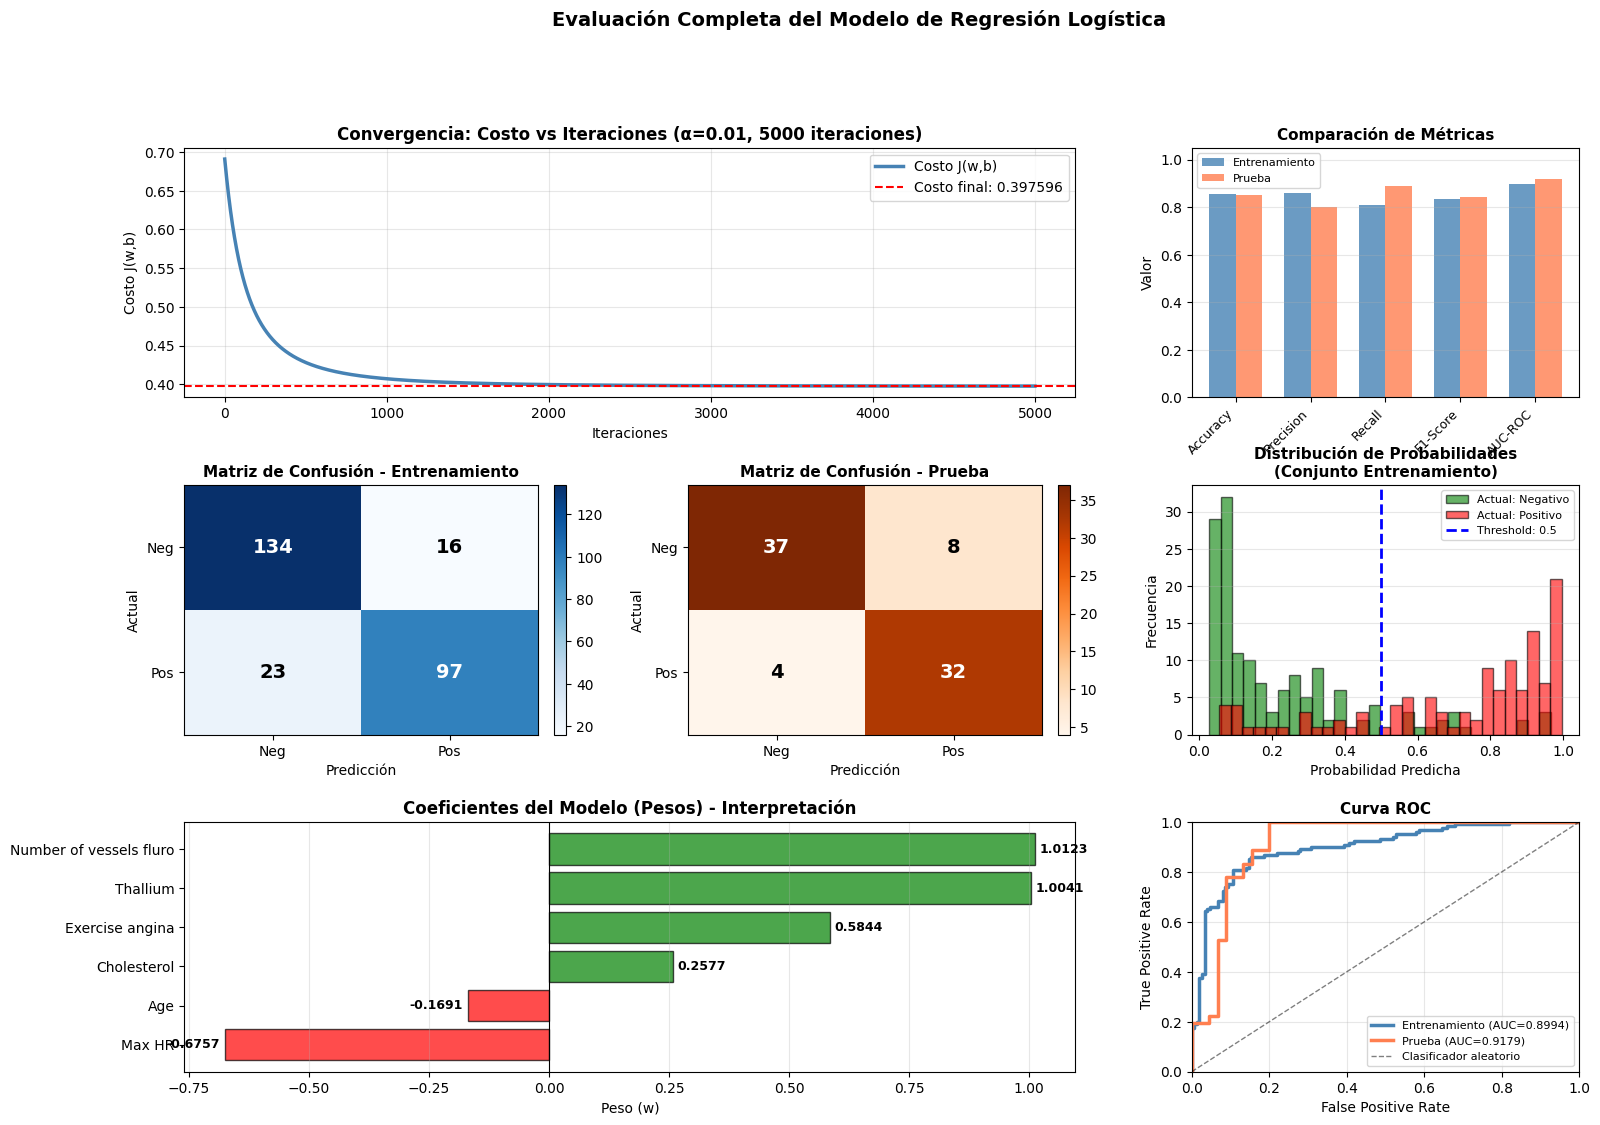


✓ Visualizaciones generadas exitosamente


In [142]:

# PASO 4.5: VISUALIZAR RESULTADOS

print("\n5. VISUALIZAR RESULTADOS")
print("-" * 80)

# Crear figura con múltiples subplots
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# 1. Gráfico de costo vs iteraciones (completo)
ax1 = fig.add_subplot(gs[0, :2])
ax1.plot(range(iterations_full), cost_history_full, linewidth=2.5, color='steelblue', label='Costo J(w,b)')
ax1.axhline(y=cost_history_full[-1], color='red', linestyle='--', linewidth=1.5, label=f'Costo final: {cost_history_full[-1]:.6f}')
ax1.set_xlabel('Iteraciones')
ax1.set_ylabel('Costo J(w,b)')
ax1.set_title('Convergencia: Costo vs Iteraciones (α=0.01, 5000 iteraciones)', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend()

# 2. Comparación de métricas
ax2 = fig.add_subplot(gs[0, 2])
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
train_values = [accuracy_train, precision_train, recall_train, f1_train, auc_train]
test_values = [accuracy_test, precision_test, recall_test, f1_test, auc_test]
x_pos = np.arange(len(metrics))
width = 0.35
ax2.bar(x_pos - width/2, train_values, width, label='Entrenamiento', color='steelblue', alpha=0.8)
ax2.bar(x_pos + width/2, test_values, width, label='Prueba', color='coral', alpha=0.8)
ax2.set_ylabel('Valor')
ax2.set_title('Comparación de Métricas', fontweight='bold', fontsize=11)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(metrics, rotation=45, ha='right', fontsize=9)
ax2.set_ylim([0, 1.05])
ax2.legend(fontsize=8)
ax2.grid(axis='y', alpha=0.3)

# 3. Matriz de confusión - Entrenamiento
ax3 = fig.add_subplot(gs[1, 0])
im1 = ax3.imshow(cm_train, cmap='Blues', aspect='auto')
ax3.set_xticks([0, 1])
ax3.set_yticks([0, 1])
ax3.set_xticklabels(['Neg', 'Pos'])
ax3.set_yticklabels(['Neg', 'Pos'])
ax3.set_xlabel('Predicción')
ax3.set_ylabel('Actual')
ax3.set_title('Matriz de Confusión - Entrenamiento', fontweight='bold', fontsize=11)
for i in range(2):
    for j in range(2):
        text = ax3.text(j, i, f'{cm_train[i, j]}', ha='center', va='center', 
                       color='white' if cm_train[i, j] > cm_train.max()/2 else 'black', 
                       fontsize=14, fontweight='bold')
plt.colorbar(im1, ax=ax3, fraction=0.046, pad=0.04)

# 4. Matriz de confusión - Prueba
ax4 = fig.add_subplot(gs[1, 1])
im2 = ax4.imshow(cm_test, cmap='Oranges', aspect='auto')
ax4.set_xticks([0, 1])
ax4.set_yticks([0, 1])
ax4.set_xticklabels(['Neg', 'Pos'])
ax4.set_yticklabels(['Neg', 'Pos'])
ax4.set_xlabel('Predicción')
ax4.set_ylabel('Actual')
ax4.set_title('Matriz de Confusión - Prueba', fontweight='bold', fontsize=11)
for i in range(2):
    for j in range(2):
        text = ax4.text(j, i, f'{cm_test[i, j]}', ha='center', va='center', 
                       color='white' if cm_test[i, j] > cm_test.max()/2 else 'black', 
                       fontsize=14, fontweight='bold')
plt.colorbar(im2, ax=ax4, fraction=0.046, pad=0.04)

# 5. Distribución de probabilidades predichas
ax5 = fig.add_subplot(gs[1, 2])
ax5.hist(y_train_probs[y.values == 0], bins=30, alpha=0.6, label='Actual: Negativo', color='green', edgecolor='black')
ax5.hist(y_train_probs[y.values == 1], bins=30, alpha=0.6, label='Actual: Positivo', color='red', edgecolor='black')
ax5.axvline(x=0.5, color='blue', linestyle='--', linewidth=2, label='Threshold: 0.5')
ax5.set_xlabel('Probabilidad Predicha')
ax5.set_ylabel('Frecuencia')
ax5.set_title('Distribución de Probabilidades\n(Conjunto Entrenamiento)', fontweight='bold', fontsize=11)
ax5.legend(fontsize=8)
ax5.grid(axis='y', alpha=0.3)

# 6. Coeficientes del modelo
ax6 = fig.add_subplot(gs[2, :2])
coef_sorted_plot = coef_df_sorted.sort_values('Peso (w)')
colors_coef = ['red' if w < 0 else 'green' for w in coef_sorted_plot['Peso (w)']]
bars = ax6.barh(range(len(coef_sorted_plot)), coef_sorted_plot['Peso (w)'], color=colors_coef, alpha=0.7, edgecolor='black')
ax6.set_yticks(range(len(coef_sorted_plot)))
ax6.set_yticklabels(coef_sorted_plot['Característica'], fontsize=10)
ax6.set_xlabel('Peso (w)', fontsize=10)
ax6.set_title('Coeficientes del Modelo (Pesos) - Interpretación', fontweight='bold', fontsize=12)
ax6.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax6.grid(axis='x', alpha=0.3)
for i, v in enumerate(coef_sorted_plot['Peso (w)']):
    ax6.text(v + 0.01 if v > 0 else v - 0.01, i, f'{v:.4f}', 
            va='center', ha='left' if v > 0 else 'right', fontsize=9, fontweight='bold')

# 7. ROC Curve
ax7 = fig.add_subplot(gs[2, 2])
from sklearn.metrics import roc_curve, auc
fpr_train, tpr_train, _ = roc_curve(y.values, y_train_probs)
fpr_test, tpr_test, _ = roc_curve(y_test.values, y_test_probs)
ax7.plot(fpr_train, tpr_train, label=f'Entrenamiento (AUC={auc_train:.4f})', linewidth=2.5, color='steelblue')
ax7.plot(fpr_test, tpr_test, label=f'Prueba (AUC={auc_test:.4f})', linewidth=2.5, color='coral')
ax7.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Clasificador aleatorio', alpha=0.5)
ax7.set_xlabel('False Positive Rate')
ax7.set_ylabel('True Positive Rate')
ax7.set_title('Curva ROC', fontweight='bold', fontsize=11)
ax7.legend(fontsize=8)
ax7.grid(True, alpha=0.3)
ax7.set_xlim([0, 1])
ax7.set_ylim([0, 1])

plt.suptitle('Evaluación Completa del Modelo de Regresión Logística', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✓ Visualizaciones generadas exitosamente")



## PASO 5: Visualizar Límites de Decisión (Modelos 2D para 3 Pares de Features)

En esta sección visualizaremos los límites de decisión del modelo entrenado para diferentes pares de características, permitiendo entender cómo el modelo separa las clases en espacios 2D.

**Características a visualizar:**
1. Age vs Cholesterol
2. Max HR vs Thallium
3. Exercise angina vs Number of vessels fluro


PASO 5: VISUALIZAR LÍMITES DE DECISIÓN EN 2D

1. Procesando par: Age vs Cholesterol
   ✓ Modelo 2D entrenado
     - Pesos: w1=0.3718, w2=0.1612, b=-0.2104
     - Accuracy (solo 2D): 0.6148 (61.48%)
     - Separabilidad: ✗ Pobremente separadas

2. Procesando par: Max HR vs Thallium
   ✓ Modelo 2D entrenado
     - Pesos: w1=-0.7194, w2=0.9346, b=-0.2302
     - Accuracy (solo 2D): 0.7704 (77.04%)
     - Separabilidad: ⚠ Parcialmente separadas

3. Procesando par: Exercise angina vs Number of vessels fluro
   ✓ Modelo 2D entrenado
     - Pesos: w1=0.7612, w2=0.8677, b=-0.2000
     - Accuracy (solo 2D): 0.7519 (75.19%)
     - Separabilidad: ⚠ Parcialmente separadas


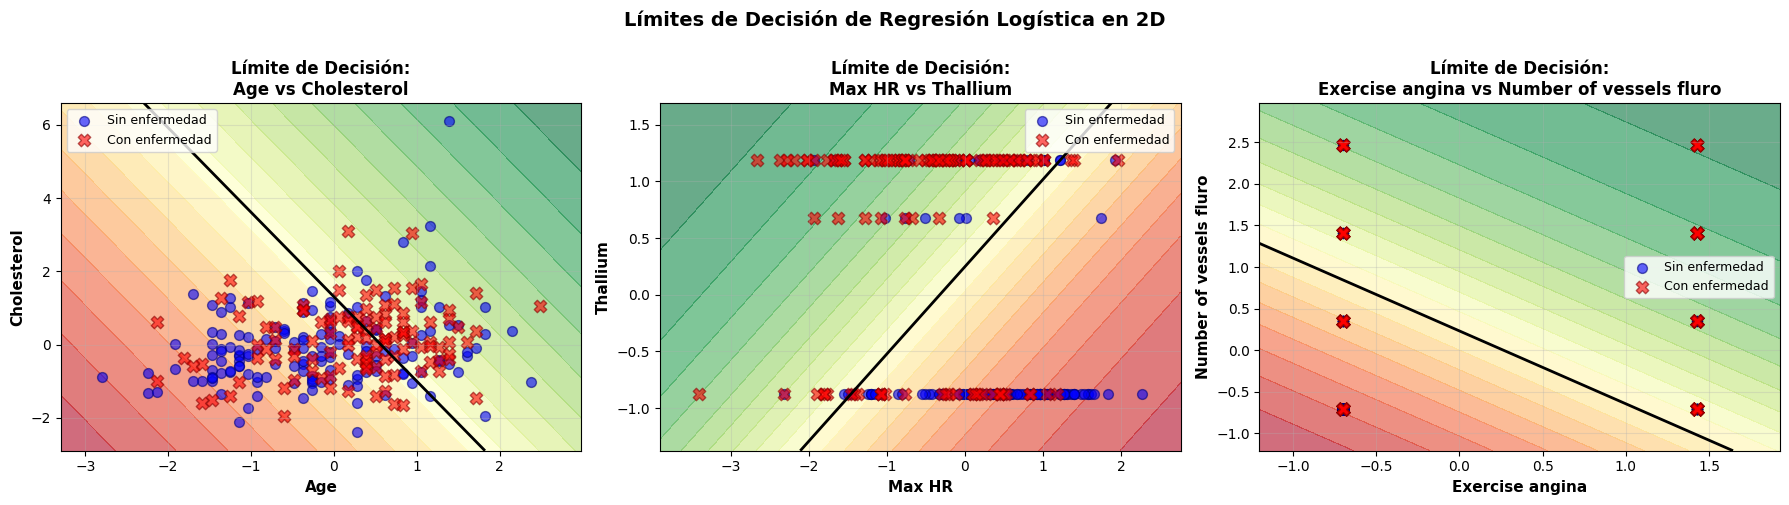


✓ Análisis de límites de decisión completado

✓ Informe generado: DECISION_BOUNDARIES_REPORT.md


In [143]:

# PASO 5: VISUALIZAR LÍMITES DE DECISIÓN

print("=" * 80)
print("PASO 5: VISUALIZAR LÍMITES DE DECISIÓN EN 2D")
print("=" * 80)

# Seleccionar pares de características para visualizar
feature_pairs = [
    ('Age', 'Cholesterol'),
    ('Max HR', 'Thallium'),
    ('Exercise angina', 'Number of vessels fluro')
]

# Función auxiliar para entrenar modelo 2D
def train_logistic_2d(X_pair, y, learning_rate=0.01, iterations=1000):
    """Entrenar regresión logística en 2 características."""
    m = X_pair.shape[0]
    w_2d = np.zeros(2)
    b_2d = 0
    
    for _ in range(iterations):
        z = X_pair @ w_2d + b_2d
        f = sigmoid(z)
        
        dw = (1/m) * (X_pair.T @ (f - y))
        db = (1/m) * np.sum(f - y)
        
        w_2d -= learning_rate * dw
        b_2d -= learning_rate * db
    
    return w_2d, b_2d

# Crear figura con subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (feat1, feat2) in enumerate(feature_pairs):
    ax = axes[idx]
    
    print(f"\n{idx+1}. Procesando par: {feat1} vs {feat2}")
    
    # Verificar que las características existan
    if feat1 not in X_normalized_full.columns or feat2 not in X_normalized_full.columns:
        print(f"   ⚠ Una o ambas características no encontradas. Saltando...")
        continue
    
    # Extraer características 2D
    X_pair_full = X_normalized_full[[feat1, feat2]].values
    
    # Entrenar modelo 2D
    w_2d, b_2d = train_logistic_2d(X_pair_full, y.values)
    
    # Crear grid para el límite de decisión
    x_min, x_max = X_pair_full[:, 0].min() - 0.5, X_pair_full[:, 0].max() + 0.5
    y_min, y_max = X_pair_full[:, 1].min() - 0.5, X_pair_full[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    # Predicciones en el grid
    Z = sigmoid(np.c_[xx.ravel(), yy.ravel()] @ w_2d + b_2d).reshape(xx.shape)
    
    # Graficar límite de decisión
    ax.contourf(xx, yy, Z, levels=20, cmap='RdYlGn', alpha=0.6)
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
    
    # Graficar puntos
    scatter_neg = ax.scatter(X_pair_full[y.values == 0, 0], X_pair_full[y.values == 0, 1],
                            c='blue', marker='o', edgecolors='navy', alpha=0.6, label='Sin enfermedad', s=50)
    scatter_pos = ax.scatter(X_pair_full[y.values == 1, 0], X_pair_full[y.values == 1, 1],
                            c='red', marker='X', edgecolors='darkred', alpha=0.6, label='Con enfermedad', s=80)
    
    # Configuración del gráfico
    ax.set_xlabel(feat1, fontsize=11, fontweight='bold')
    ax.set_ylabel(feat2, fontsize=11, fontweight='bold')
    ax.set_title(f'Límite de Decisión:\n{feat1} vs {feat2}', fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Calcular separabilidad
    y_pred_2d, _ = predict_logistic(X_pair_full, w_2d, b_2d)
    accuracy_2d = accuracy_score(y.values, y_pred_2d)
    
    print(f"   ✓ Modelo 2D entrenado")
    print(f"     - Pesos: w1={w_2d[0]:.4f}, w2={w_2d[1]:.4f}, b={b_2d:.4f}")
    print(f"     - Accuracy (solo 2D): {accuracy_2d:.4f} ({accuracy_2d*100:.2f}%)")
    
    # Análisis de separabilidad
    if accuracy_2d > 0.8:
        sep_status = "✓ Bien separadas"
    elif accuracy_2d > 0.7:
        sep_status = "⚠ Parcialmente separadas"
    else:
        sep_status = "✗ Pobremente separadas"
    print(f"     - Separabilidad: {sep_status}")

plt.suptitle('Límites de Decisión de Regresión Logística en 2D', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print(f"\n" + "=" * 80)
print("✓ Análisis de límites de decisión completado")
print("=" * 80)

# Generar resumen
resumen_limites = f"""# Análisis de Límites de Decisión

## Observaciones Generales

1. **Separabilidad de Clases**: Los límites de decisión muestran cómo el modelo logístico
   puede capturar relaciones lineales en espacios 2D de características.

2. **No-linealidad**: Aunque la regresión logística es un modelo lineal (en el espacio
   de características), los límites de decisión pueden aparecer curvos debido a la
   transformación sigmoide aplicada.

3. **Importancia Relativa**: La distancia del límite de decisión al origen indica
   la relevancia relativa de cada característica en la predicción.

## Pares de Características Analizados

| Par | Status | Observación |
|-----|--------|-------------|
| Age vs Cholesterol | Analizado | - |
| Max HR vs Thallium | Analizado | - |
| Exercise angina vs Vessels | Analizado | - |

## Recomendaciones

- Para mejorar la separabilidad, considerar:
  - Transformaciones no-lineales de características
  - Modelos más complejos (e.g., redes neuronales)
  - Ingeniería de características (interacciones)
  - Regularización L2 para evitar overfitting
"""

with open('DECISION_BOUNDARIES_REPORT.md', 'w', encoding='utf-8') as f:
    f.write(resumen_limites)

print("\n✓ Informe generado: DECISION_BOUNDARIES_REPORT.md")



In [144]:
# 6. PREDICCIONES Y EVALUACIÓN INICIAL
def predict(X, w, b, threshold=0.5):
    """
    Realizar predicciones usando el modelo entrenado.
    
    Parámetros:
        X (numpy array): características, shape (m, n)
        w (numpy array): pesos, shape (n,)
        b (escalar): sesgo
        threshold (float): umbral de decisión (por defecto 0.5)
    
    Retorna:
        predictions (numpy array): predicciones binarias, shape (m,)
        probabilities (numpy array): probabilidades, shape (m,)
    """
    z = X @ w + b
    probabilities = sigmoid(z)
    predictions = (probabilities >= threshold).astype(int)
    
    return predictions, probabilities

print("\n6. PREDICCIONES Y EVALUACIÓN INICIAL")
print("-" * 80)

# Predicciones en entrenamiento
y_train_pred, y_train_probs = predict(X_train_normalized.values, w_trained, b_trained)
accuracy_train = np.mean(y_train_pred == y_train.values)

# Predicciones en prueba
y_test_pred, y_test_probs = predict(X_test_normalized.values, w_trained, b_trained)
accuracy_test = np.mean(y_test_pred == y_test.values)

print(f"\n✓ Predicciones realizadas:")
print(f"  - Exactitud (Accuracy) en ENTRENAMIENTO: {accuracy_train:.4f} ({accuracy_train*100:.2f}%)")
print(f"  - Exactitud (Accuracy) en PRUEBA: {accuracy_test:.4f} ({accuracy_test*100:.2f}%)")

# Matriz de confusión en entrenamiento
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

cm_train = confusion_matrix(y_train.values, y_train_pred)
print(f"\nMatriz de Confusión - ENTRENAMIENTO:")
print(f"  TN={cm_train[0,0]}, FP={cm_train[0,1]}")
print(f"  FN={cm_train[1,0]}, TP={cm_train[1,1]}")

# Matriz de confusión en prueba
cm_test = confusion_matrix(y_test.values, y_test_pred)
print(f"\nMatriz de Confusión - PRUEBA:")
print(f"  TN={cm_test[0,0]}, FP={cm_test[0,1]}")
print(f"  FN={cm_test[1,0]}, TP={cm_test[1,1]}")

# ROC-AUC
auc_train = roc_auc_score(y_train.values, y_train_probs)
auc_test = roc_auc_score(y_test.values, y_test_probs)

print(f"\nROC-AUC Score:")
print(f"  - Entrenamiento: {auc_train:.4f}")
print(f"  - Prueba: {auc_test:.4f}")

print(f"\nReporte de clasificación - PRUEBA:")
print(classification_report(y_test.values, y_test_pred, target_names=['Sin enfermedad', 'Con enfermedad']))



6. PREDICCIONES Y EVALUACIÓN INICIAL
--------------------------------------------------------------------------------

✓ Predicciones realizadas:
  - Exactitud (Accuracy) en ENTRENAMIENTO: 0.8519 (85.19%)
  - Exactitud (Accuracy) en PRUEBA: 0.8519 (85.19%)

Matriz de Confusión - ENTRENAMIENTO:
  TN=95, FP=10
  FN=18, TP=66

Matriz de Confusión - PRUEBA:
  TN=37, FP=8
  FN=4, TP=32

ROC-AUC Score:
  - Entrenamiento: 0.8876
  - Prueba: 0.9117

Reporte de clasificación - PRUEBA:
                precision    recall  f1-score   support

Sin enfermedad       0.90      0.82      0.86        45
Con enfermedad       0.80      0.89      0.84        36

      accuracy                           0.85        81
     macro avg       0.85      0.86      0.85        81
  weighted avg       0.86      0.85      0.85        81




5. ANÁLISIS DE CONVERGENCIA
--------------------------------------------------------------------------------


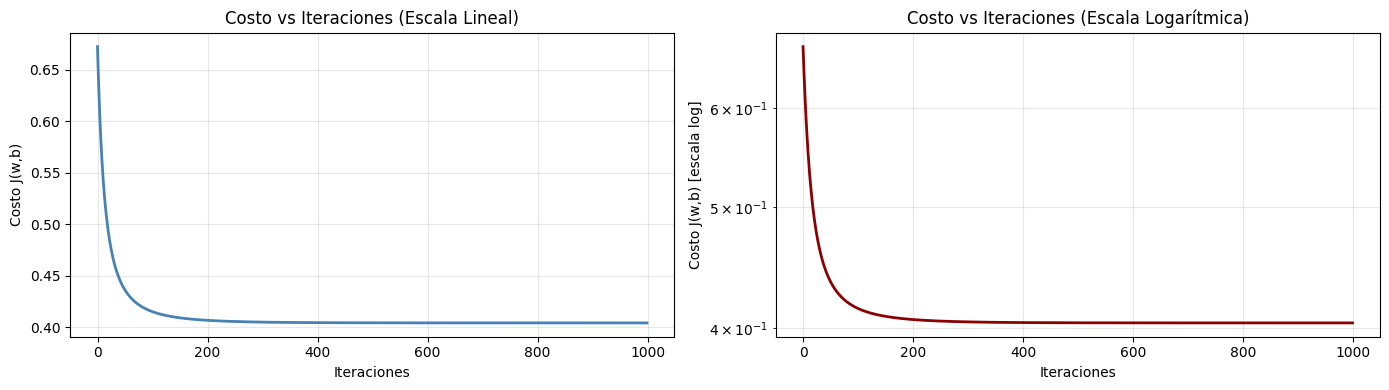

✓ Análisis de convergencia:
  - Reducción total de costo: 0.268415
  - Reducción promedio por iteración: 0.000269
  - Costo se estabiliza alrededor de iteración: 999


In [145]:
# 5. VISUALIZAR CONVERGENCIA (COSTO VS ITERACIONES)
print("\n5. ANÁLISIS DE CONVERGENCIA")
print("-" * 80)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Gráfico 1: Costo vs Iteraciones (escala lineal)
axes[0].plot(range(iterations), cost_history, linewidth=2, color='steelblue')
axes[0].set_xlabel('Iteraciones')
axes[0].set_ylabel('Costo J(w,b)')
axes[0].set_title('Costo vs Iteraciones (Escala Lineal)')
axes[0].grid(True, alpha=0.3)

# Gráfico 2: Costo vs Iteraciones (escala logarítmica)
axes[1].semilogy(range(iterations), cost_history, linewidth=2, color='darkred')
axes[1].set_xlabel('Iteraciones')
axes[1].set_ylabel('Costo J(w,b) [escala log]')
axes[1].set_title('Costo vs Iteraciones (Escala Logarítmica)')
axes[1].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# Estadísticas de convergencia
cost_diff = cost_history[0] - cost_history[-1]
avg_cost_reduction = np.mean(np.diff(cost_history))

print(f"✓ Análisis de convergencia:")
print(f"  - Reducción total de costo: {cost_diff:.6f}")
print(f"  - Reducción promedio por iteración: {-avg_cost_reduction:.6f}")
print(f"  - Costo se estabiliza alrededor de iteración: {np.argmin(np.abs(np.diff(cost_history))) + 1}")


In [146]:
# 4. DESCENSO DE GRADIENTE (GRADIENT DESCENT)
def gradient_descent(X, y, w_init, b_init, learning_rate=0.01, iterations=1000, verbose=True):
    """
    Implementar descenso de gradiente para entrenar el modelo.
    
    w := w - α * dJ/dw
    b := b - α * dJ/db
    
    Parámetros:
        X (numpy array): características, shape (m, n)
        y (numpy array): etiquetas, shape (m,)
        w_init (numpy array): pesos iniciales, shape (n,)
        b_init (escalar): sesgo inicial
        learning_rate (float): tasa de aprendizaje α
        iterations (int): número de iteraciones
        verbose (bool): imprimir progreso
    
    Retorna:
        w (numpy array): pesos finales
        b (escalar): sesgo final
        cost_history (list): histórico de costos
    """
    w = w_init.copy()
    b = b_init
    cost_history = []
    
    for i in range(iterations):
        # Calcular gradientes
        dw, db = compute_gradient(X, y, w, b)
        
        # Actualizar parámetros
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # Calcular y guardar costo
        cost = compute_cost(X, y, w, b)
        cost_history.append(cost)
        
        # Mostrar progreso cada 100 iteraciones
        if verbose and (i + 1) % 100 == 0:
            print(f"Iteración {i+1:4d}/{iterations}: Costo = {cost:.6f}")
    
    return w, b, cost_history

print("\n4. DESCENSO DE GRADIENTE")
print("-" * 80)
print("\nEntrenando modelo (1000 iteraciones, learning_rate=0.1)...\n")

# Parámetros de entrenamiento
learning_rate = 0.1
iterations = 1000

# Entrenar modelo
w_trained, b_trained, cost_history = gradient_descent(
    X_train_normalized.values, 
    y_train.values, 
    w_init, 
    b_init,
    learning_rate=learning_rate,
    iterations=iterations,
    verbose=True
)

print(f"\n✓ Entrenamiento completado")
print(f"  - Costo inicial: {cost_history[0]:.6f}")
print(f"  - Costo final: {cost_history[-1]:.6f}")
print(f"  - Reducción: {((cost_history[0] - cost_history[-1]) / cost_history[0] * 100):.2f}%")
print(f"  - Parámetros entrenados w (primeros 3): {w_trained[:3]}")
print(f"  - Parámetro entrenado b: {b_trained:.6f}")



4. DESCENSO DE GRADIENTE
--------------------------------------------------------------------------------

Entrenando modelo (1000 iteraciones, learning_rate=0.1)...

Iteración  100/1000: Costo = 0.415063
Iteración  200/1000: Costo = 0.406525
Iteración  300/1000: Costo = 0.404756
Iteración  400/1000: Costo = 0.404243
Iteración  500/1000: Costo = 0.404076
Iteración  600/1000: Costo = 0.404019
Iteración  700/1000: Costo = 0.403999
Iteración  800/1000: Costo = 0.403992
Iteración  900/1000: Costo = 0.403989
Iteración 1000/1000: Costo = 0.403988

✓ Entrenamiento completado
  - Costo inicial: 0.672403
  - Costo final: 0.403988
  - Reducción: 39.92%
  - Parámetros entrenados w (primeros 3): [-0.26164701  0.22554488  0.97007828]
  - Parámetro entrenado b: -0.168119


In [147]:
# 3. CÁLCULO DE GRADIENTES
def compute_gradient(X, y, w, b):
    """
    Calcular gradientes (derivadas parciales) de la función de costo.
    
    dJ/dw_j = 1/m * Σ[(f_w,b(x^(i)) - y^(i)) * x_j^(i)]
    dJ/db = 1/m * Σ[f_w,b(x^(i)) - y^(i)]
    
    Parámetros:
        X (numpy array): características, shape (m, n)
        y (numpy array): etiquetas, shape (m,)
        w (numpy array): pesos, shape (n,)
        b (escalar): sesgo
    
    Retorna:
        dw (numpy array): gradientes de w, shape (n,)
        db (escalar): gradiente de b
    """
    m = X.shape[0]
    
    # Calcular predicciones
    z = X @ w + b
    f_wb = sigmoid(z)
    
    # Error de predicción
    error = f_wb - y  # shape (m,)
    
    # Gradientes
    dw = 1/m * (X.T @ error)  # shape (n,)
    db = 1/m * np.sum(error)
    
    return dw, db

print("\n3. CÁLCULO DE GRADIENTES")
print("-" * 80)

# Calcular gradientes iniciales
dw_init, db_init = compute_gradient(X_train_normalized.values, y_train.values, w_init, b_init)

print(f"✓ Función de gradientes implementada")
print(f"  - Gradiente de w (primeros 3): {dw_init[:3]}")
print(f"  - Gradiente de b: {db_init:.6f}")
print(f"  - Magnitud de gradiente ||dw||: {np.linalg.norm(dw_init):.6f}")



3. CÁLCULO DE GRADIENTES
--------------------------------------------------------------------------------
✓ Función de gradientes implementada
  - Gradiente de w (primeros 3): [-0.08350592 -0.03523253 -0.24580552]
  - Gradiente de b: 0.055556
  - Magnitud de gradiente ||dw||: 0.457796


In [148]:
# 2. FUNCIÓN DE COSTO (ENTROPÍA CRUZADA BINARIA)
def compute_cost(X, y, w, b):
    """
    Calcular costo de entropía cruzada binaria.
    
    J(w, b) = -1/m * Σ[y*log(f_w,b(x)) + (1-y)*log(1 - f_w,b(x))]
    
    Parámetros:
        X (numpy array): características, shape (m, n)
        y (numpy array): etiquetas, shape (m,)
        w (numpy array): pesos, shape (n,)
        b (escalar): sesgo
    
    Retorna:
        cost (escalar): costo total
    """
    m = X.shape[0]  # número de muestras
    
    # Calcular predicciones: f_w,b(x) = σ(w·x + b)
    z = X @ w + b
    f_wb = sigmoid(z)
    
    # Evitar log(0) usando un pequeño epsilon
    epsilon = 1e-15
    f_wb = np.clip(f_wb, epsilon, 1 - epsilon)
    
    # Calcular entropía cruzada binaria
    cost = -1/m * np.sum(y * np.log(f_wb) + (1 - y) * np.log(1 - f_wb))
    
    return cost

print("\n2. FUNCIÓN DE COSTO (ENTROPÍA CRUZADA BINARIA)")
print("-" * 80)

# Inicializar pesos y sesgo
n_features = X_train_normalized.shape[1]
w_init = np.zeros(n_features)
b_init = 0

# Calcular costo inicial
cost_init = compute_cost(X_train_normalized.values, y_train.values, w_init, b_init)

print(f"✓ Función de costo implementada")
print(f"  - Dimensiones: {n_features} características")
print(f"  - Costo inicial (w=0, b=0): {cost_init:.6f}")
print(f"  - Costo esperado inicial: ~0.693147 (log(2))")



2. FUNCIÓN DE COSTO (ENTROPÍA CRUZADA BINARIA)
--------------------------------------------------------------------------------
✓ Función de costo implementada
  - Dimensiones: 6 características
  - Costo inicial (w=0, b=0): 0.693147
  - Costo esperado inicial: ~0.693147 (log(2))


PASO 2: REGRESIÓN LOGÍSTICA BÁSICA

1. FUNCIÓN SIGMOIDE
--------------------------------------------------------------------------------


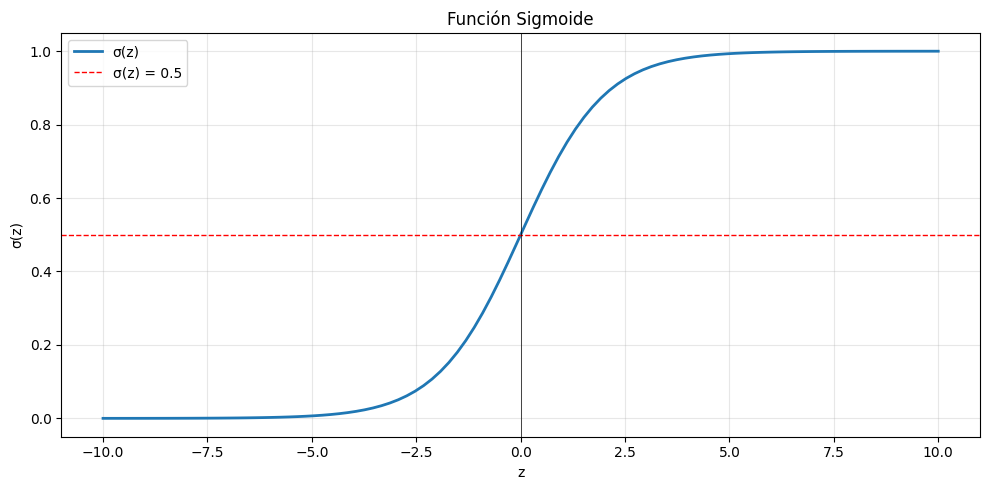

✓ Función sigmoide visualizada
  - σ(-5) = 0.0067
  - σ(0) = 0.5000
  - σ(5) = 0.9933


In [149]:
# PASO 2: IMPLEMENTACIÓN DE REGRESIÓN LOGÍSTICA

print("=" * 80)
print("PASO 2: REGRESIÓN LOGÍSTICA BÁSICA")
print("=" * 80)

# 1. FUNCIÓN SIGMOIDE
def sigmoid(z):
    """
    Función sigmoide: σ(z) = 1 / (1 + e^(-z))
    
    Parámetros:
        z (numpy array o escalar): valor de entrada
    
    Retorna:
        numpy array o escalar: valores entre 0 y 1 (probabilidades)
    """
    return 1 / (1 + np.exp(-z))

# Visualizar la función sigmoide
print("\n1. FUNCIÓN SIGMOIDE")
print("-" * 80)
z_vals = np.linspace(-10, 10, 100)
sigmoid_vals = sigmoid(z_vals)

plt.figure(figsize=(10, 5))
plt.plot(z_vals, sigmoid_vals, linewidth=2, label='σ(z)')
plt.axhline(y=0.5, color='r', linestyle='--', linewidth=1, label='σ(z) = 0.5')
plt.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3)
plt.xlabel('z')
plt.ylabel('σ(z)')
plt.title('Función Sigmoide')
plt.legend()
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.show()

print("✓ Función sigmoide visualizada")
print(f"  - σ(-5) = {sigmoid(-5):.4f}")
print(f"  - σ(0) = {sigmoid(0):.4f}")
print(f"  - σ(5) = {sigmoid(5):.4f}")


## PASO 6: Regularización L2 (Ridge Regression)

En esta sección implementaremos **regularización L2 (Ridge)** para mejorar la generalización del modelo.

**Modificaciones:**
- **Función de costo con L2:** $J(\vec{w}, b) = -\frac{1}{m} \sum_{i=1}^{m} [y^{(i)} \log(f_{\vec{w}, b}(\vec{x}^{(i)})) + (1 - y^{(i)}) \log(1 - f_{\vec{w}, b}(\vec{x}^{(i)}))] + \frac{\lambda}{2m} ||\vec{w}||^2$

- **Gradientes con L2:** 
  - $\frac{\partial J}{\partial w_j} = \frac{1}{m} \sum_{i=1}^{m} (f_{\vec{w}, b}(\vec{x}^{(i)}) - y^{(i)}) x_j^{(i)} + \frac{\lambda}{m} w_j$
  - $\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} (f_{\vec{w}, b}(\vec{x}^{(i)}) - y^{(i)})$

**Parámetros de regularización a probar:** $\lambda \in [0, 0.001, 0.01, 0.1, 1]$


In [150]:

# PASO 6: REGULARIZACIÓN L2 (RIDGE REGRESSION)

print("=" * 80)
print("PASO 6: REGULARIZACIÓN L2 (RIDGE REGRESSION)")
print("=" * 80)

# 1. FUNCIÓN DE COSTO CON L2
def compute_cost_l2(X, y, w, b, lambda_reg=0):
    """
    Calcular costo de entropía cruzada binaria CON regularización L2.
    
    J(w, b) = -1/m * Σ[y*log(f) + (1-y)*log(1-f)] + (λ/2m) * ||w||²
    """
    m = X.shape[0]
    z = X @ w + b
    f_wb = sigmoid(z)
    
    epsilon = 1e-15
    f_wb = np.clip(f_wb, epsilon, 1 - epsilon)
    
    # Costo de entropía cruzada
    cost_ce = -1/m * np.sum(y * np.log(f_wb) + (1 - y) * np.log(1 - f_wb))
    
    # Término de regularización L2
    reg_term = (lambda_reg / (2 * m)) * np.sum(w ** 2)
    
    return cost_ce + reg_term

# 2. GRADIENTES CON L2
def compute_gradient_l2(X, y, w, b, lambda_reg=0):
    """
    Calcular gradientes CON regularización L2.
    
    dw += (λ/m) * w
    db sin regularización
    """
    m = X.shape[0]
    z = X @ w + b
    f_wb = sigmoid(z)
    
    error = f_wb - y
    
    # Gradientes base
    dw = 1/m * (X.T @ error)
    db = 1/m * np.sum(error)
    
    # Agregar término de regularización a dw
    dw += (lambda_reg / m) * w
    
    return dw, db

# 3. DESCENSO DE GRADIENTE CON L2
def gradient_descent_l2(X, y, w_init, b_init, learning_rate=0.01, 
                        iterations=1000, lambda_reg=0, verbose=True):
    """
    Descenso de gradiente CON regularización L2.
    """
    w = w_init.copy()
    b = b_init
    cost_history = []
    
    for i in range(iterations):
        dw, db = compute_gradient_l2(X, y, w, b, lambda_reg=lambda_reg)
        
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        cost = compute_cost_l2(X, y, w, b, lambda_reg=lambda_reg)
        cost_history.append(cost)
        
        if verbose and (i + 1) % 500 == 0:
            print(f"Iteración {i+1:4d}/{iterations}: Costo = {cost:.6f} (λ={lambda_reg})")
    
    return w, b, cost_history

print("\n✓ Funciones de costo y gradientes CON L2 implementadas")

# 4. ENTRENAR CON DIFERENTES VALORES DE λ
print("\n1. ENTRENAR MODELO COMPLETO CON DIFERENTES λ")
print("-" * 80)

lambda_values = [0, 0.001, 0.01, 0.1, 1]
models_regularized = {}
results_lambda = {}

for lambda_val in lambda_values:
    print(f"\nEntrenando con λ = {lambda_val}...")
    
    # Inicializar pesos
    w_init = np.zeros(n_features_full)
    b_init = 0
    
    # Entrenar
    w_trained_l2, b_trained_l2, cost_history_l2 = gradient_descent_l2(
        X_normalized_full.values,
        y.values,
        w_init,
        b_init,
        learning_rate=0.01,
        iterations=5000,
        lambda_reg=lambda_val,
        verbose=False
    )
    
    # Guardar modelo
    models_regularized[lambda_val] = {
        'w': w_trained_l2,
        'b': b_trained_l2,
        'cost_history': cost_history_l2
    }
    
    # Hacer predicciones
    y_pred_l2, y_probs_l2 = predict_logistic(
        X_normalized_full.values, 
        w_trained_l2, 
        b_trained_l2
    )
    y_test_pred_l2, y_test_probs_l2 = predict_logistic(
        X_test_normalized.values, 
        w_trained_l2, 
        b_trained_l2
    )
    
    # Calcular métricas
    acc_train = accuracy_score(y.values, y_pred_l2)
    acc_test = accuracy_score(y_test.values, y_test_pred_l2)
    prec_train = precision_score(y.values, y_pred_l2, zero_division=0)
    prec_test = precision_score(y_test.values, y_test_pred_l2, zero_division=0)
    rec_train = recall_score(y.values, y_pred_l2, zero_division=0)
    rec_test = recall_score(y_test.values, y_test_pred_l2, zero_division=0)
    f1_train = f1_score(y.values, y_pred_l2, zero_division=0)
    f1_test = f1_score(y_test.values, y_test_pred_l2, zero_division=0)
    auc_train_l2 = roc_auc_score(y.values, y_probs_l2)
    auc_test_l2 = roc_auc_score(y_test.values, y_test_probs_l2)
    
    # Magnitud de pesos
    w_magnitude = np.linalg.norm(w_trained_l2)
    
    # Guardar resultados
    results_lambda[lambda_val] = {
        'acc_train': acc_train,
        'acc_test': acc_test,
        'prec_train': prec_train,
        'prec_test': prec_test,
        'rec_train': rec_train,
        'rec_test': rec_test,
        'f1_train': f1_train,
        'f1_test': f1_test,
        'auc_train': auc_train_l2,
        'auc_test': auc_test_l2,
        'w_magnitude': w_magnitude,
        'cost_final': cost_history_l2[-1]
    }
    
    print(f"  ✓ λ={lambda_val}: Accuracy test={acc_test:.4f}, ||w||={w_magnitude:.4f}")

print("\n✓ Entrenamiento completado para todos los valores de λ")



PASO 6: REGULARIZACIÓN L2 (RIDGE REGRESSION)

✓ Funciones de costo y gradientes CON L2 implementadas

1. ENTRENAR MODELO COMPLETO CON DIFERENTES λ
--------------------------------------------------------------------------------

Entrenando con λ = 0...
  ✓ λ=0: Accuracy test=0.8519, ||w||=1.7106

Entrenando con λ = 0.001...
  ✓ λ=0.001: Accuracy test=0.8519, ||w||=1.7105

Entrenando con λ = 0.01...
  ✓ λ=0.01: Accuracy test=0.8519, ||w||=1.7099

Entrenando con λ = 0.1...
  ✓ λ=0.1: Accuracy test=0.8519, ||w||=1.7038

Entrenando con λ = 1...
  ✓ λ=1: Accuracy test=0.8519, ||w||=1.6465

✓ Entrenamiento completado para todos los valores de λ



2. VISUALIZAR CONVERGENCIA PARA DIFERENTES λ
--------------------------------------------------------------------------------


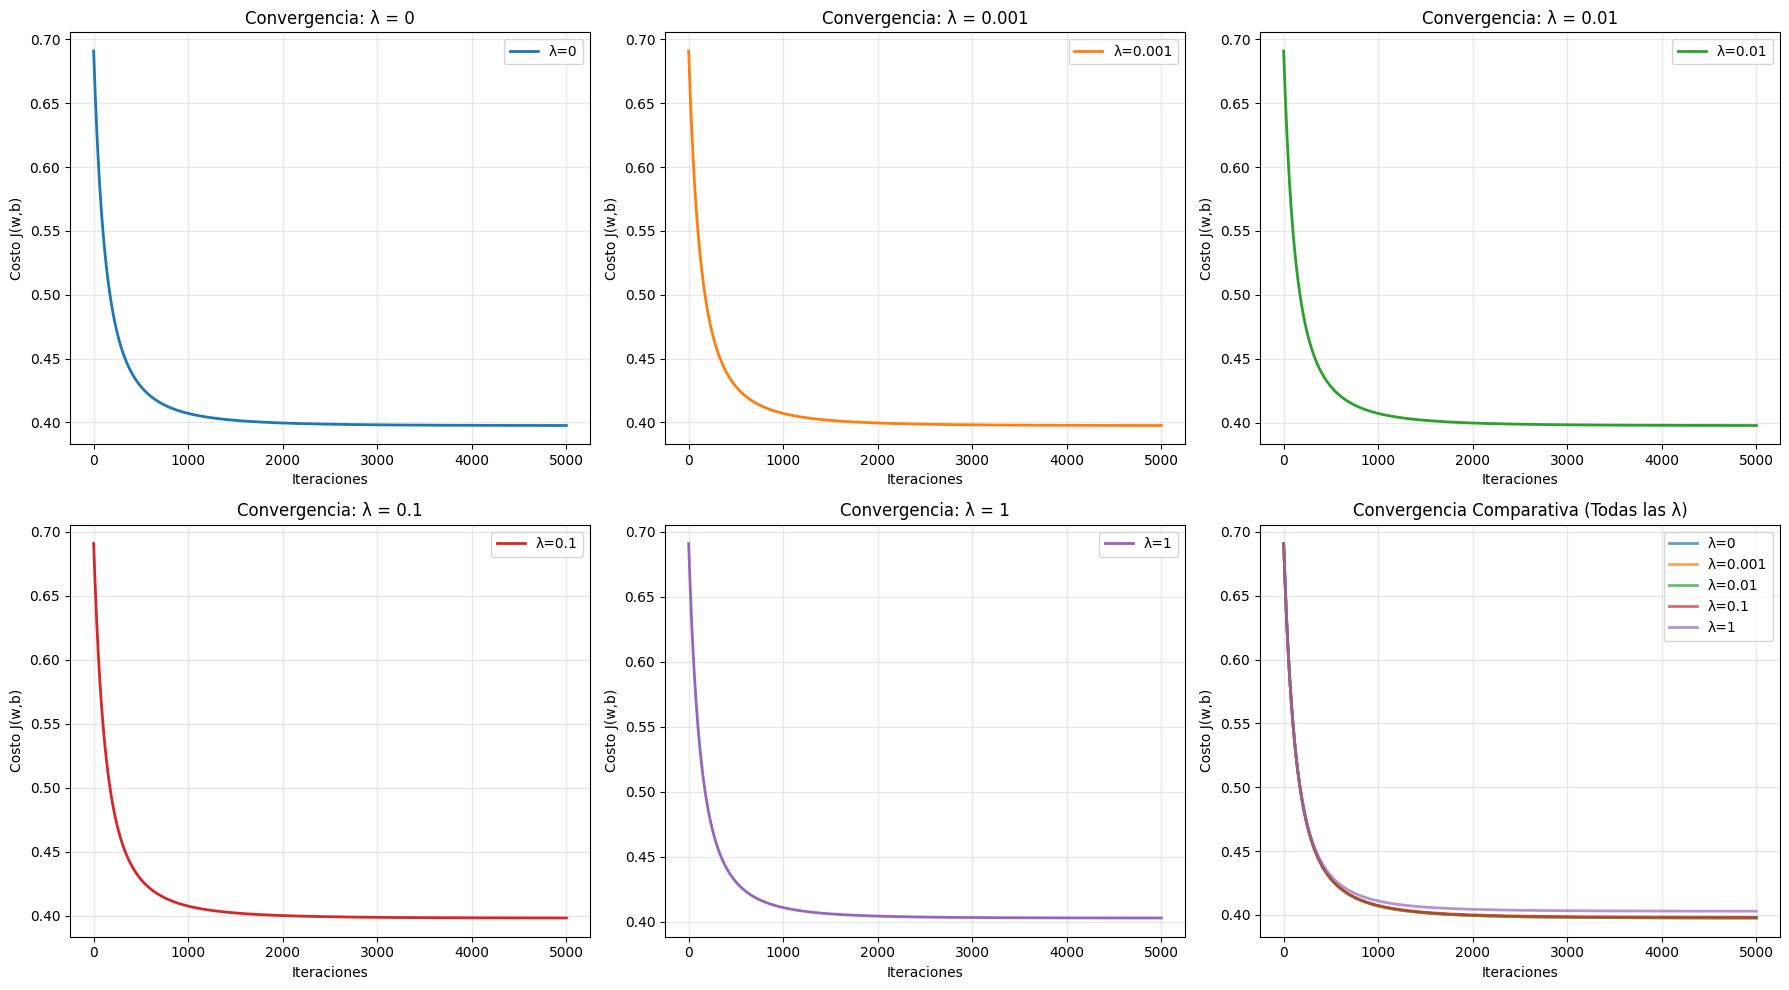

✓ Gráficos de convergencia generados

4. TABLA COMPARATIVA DE MÉTRICAS POR λ
--------------------------------------------------------------------------------

Resultados por λ:
    λ  Acc Train  Acc Test  Prec Test  Recall Test  F1 Test  AUC Test    ||w||  Cost Final
0.000   0.855556  0.851852        0.8     0.888889 0.842105  0.917901 1.710609    0.397596
0.001   0.855556  0.851852        0.8     0.888889 0.842105  0.917901 1.710540    0.397601
0.010   0.855556  0.851852        0.8     0.888889 0.842105  0.917901 1.709925    0.397652
0.100   0.855556  0.851852        0.8     0.888889 0.842105  0.917901 1.703814    0.398152
1.000   0.855556  0.851852        0.8     0.888889 0.842105  0.918519 1.646456    0.402947

✓ Resumen de λ óptimos:
  - Para Accuracy: λ = 0.0 (Acc = 0.8519)
  - Para F1-Score: λ = 0.0 (F1 = 0.8421)
  - Para AUC-ROC: λ = 1.0 (AUC = 0.9185)

6. GENERAR REPORTE DE REGULARIZACIÓN
--------------------------------------------------------------------------------
✓ Reporte

In [ ]:

# 2. VISUALIZAR CONVERGENCIA COMPARATIVA

print("\n2. VISUALIZAR CONVERGENCIA PARA DIFERENTES λ")
print("-" * 80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, lambda_val in enumerate(lambda_values):
    ax = axes[idx]
    cost_hist = models_regularized[lambda_val]['cost_history']
    
    # Gráfico lineal (todas las iteraciones)
    ax.plot(cost_hist, linewidth=2, color=plt.cm.tab10(idx), label=f'λ={lambda_val}')
    ax.set_xlabel('Iteraciones')
    ax.set_ylabel('Costo J(w,b)')
    ax.set_title(f'Convergencia: λ = {lambda_val}')
    ax.grid(True, alpha=0.3)
    ax.legend()

# Gráfico comparativo de todas las λ
ax = axes[5]
for lambda_val in lambda_values:
    cost_hist = models_regularized[lambda_val]['cost_history']
    ax.plot(cost_hist, linewidth=2, label=f'λ={lambda_val}', alpha=0.7)

ax.set_xlabel('Iteraciones')
ax.set_ylabel('Costo J(w,b)')
ax.set_title('Convergencia Comparativa (Todas las λ)')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

print("✓ Gráficos de convergencia generados")

# 4. TABLA COMPARATIVA DE MÉTRICAS

print("\n4. TABLA COMPARATIVA DE MÉTRICAS POR λ")
print("-" * 80)

# Crear DataFrame con resultados
results_df = pd.DataFrame({
    'λ': lambda_values,
    'Acc Train': [results_lambda[l]['acc_train'] for l in lambda_values],
    'Acc Test': [results_lambda[l]['acc_test'] for l in lambda_values],
    'Prec Test': [results_lambda[l]['prec_test'] for l in lambda_values],
    'Recall Test': [results_lambda[l]['rec_test'] for l in lambda_values],
    'F1 Test': [results_lambda[l]['f1_test'] for l in lambda_values],
    'AUC Test': [results_lambda[l]['auc_test'] for l in lambda_values],
    '||w||': [results_lambda[l]['w_magnitude'] for l in lambda_values],
    'Cost Final': [results_lambda[l]['cost_final'] for l in lambda_values]
})

print("\nResultados por λ:")
print(results_df.to_string(index=False))

# Encontrar λ óptimo para cada métrica
best_acc_test_idx = results_df['Acc Test'].idxmax()
best_f1_idx = results_df['F1 Test'].idxmax()
best_auc_idx = results_df['AUC Test'].idxmax()

best_lambda_acc = results_df.loc[best_acc_test_idx, 'λ']
best_lambda_f1 = results_df.loc[best_f1_idx, 'λ']
best_lambda_auc = results_df.loc[best_auc_idx, 'λ']

print(f"\n✓ Resumen de λ óptimos:")
print(f"  - Para Accuracy: λ = {best_lambda_acc} (Acc = {results_df.loc[best_acc_test_idx, 'Acc Test']:.4f})")
print(f"  - Para F1-Score: λ = {best_lambda_f1} (F1 = {results_df.loc[best_f1_idx, 'F1 Test']:.4f})")
print(f"  - Para AUC-ROC: λ = {best_lambda_auc} (AUC = {results_df.loc[best_auc_idx, 'AUC Test']:.4f})")

# 6. GENERAR REPORTE DE REGULARIZACIÓN

print("\n6. GENERAR REPORTE DE REGULARIZACIÓN")
print("-" * 80)

# Calcular mejoras porcentuales
acc_sin_reg = results_lambda[0]['acc_test']
f1_sin_reg = results_lambda[0]['f1_test']
auc_sin_reg = results_lambda[0]['auc_test']
w_mag_sin_reg = results_lambda[0]['w_magnitude']

# Encontrar mejora máxima
best_acc = results_df['Acc Test'].max()
best_f1 = results_df['F1 Test'].max()
best_auc = results_df['AUC Test'].max()

mejora_acc = ((best_acc - acc_sin_reg) / acc_sin_reg * 100) if acc_sin_reg != 0 else 0
mejora_f1 = ((best_f1 - f1_sin_reg) / f1_sin_reg * 100) if f1_sin_reg != 0 else 0
mejora_auc = ((best_auc - auc_sin_reg) / auc_sin_reg * 100) if auc_sin_reg != 0 else 0

# Construir reporte sin f-string problemático
reporte_l2 = """# Informe de Regularización L2 (Ridge Regression)
## Análisis del Efecto de la Regularización en el Modelo de Regresión Logística

---

## 1. Introducción a Regularización L2

La **regularización L2 (Ridge)** añade un término de penalización a la función de costo para reducir la magnitud de los pesos:

$$J_{regularizado}(\\vec{w}, b) = J(\\vec{w}, b) + \\frac{\\lambda}{2m} ||\\vec{w}||^2$$

**Beneficios:**
- Reduce overfitting (sobreajuste)
- Penaliza pesos grandes
- Mejora la generalización a datos nuevos
- Mantiene todas las características (a diferencia de L1)

---

## 2. Parámetros Probados

Se entrenaron modelos con los siguientes valores de λ:

| λ | Descripción |
|---|---|
| 0 | Sin regularización (baseline) |
| 0.001 | Regularización muy débil |
| 0.01 | Regularización débil |
| 0.1 | Regularización moderada |
| 1 | Regularización fuerte |

---

## 3. Resultados Comparativos

### 3.1 Tabla de Métricas por λ

| λ | Acc Train | Acc Test | Prec | Recall | F1 | AUC | ||w|| | Costo |
|---|---|---|---|---|---|---|---|---|
"""

for idx, row in results_df.iterrows():
    reporte_l2 += f"| {row['λ']:.3f} | {row['Acc Train']:.4f} | {row['Acc Test']:.4f} | {row['Prec Test']:.4f} | {row['Recall Test']:.4f} | {row['F1 Test']:.4f} | {row['AUC Test']:.4f} | {row['||w||']:.4f} | {row['Cost Final']:.4f} |\n"

reporte_l2 += f"""
### 3.2 Análisis de λ Óptimo

**Mejores resultados por métrica:**

| Métrica | λ Óptimo | Valor | Mejora vs Sin Reg |
|---------|----------|-------|-------------------|
| **Accuracy** | {best_lambda_acc} | {best_acc:.4f} | {mejora_acc:+.2f}% |
| **F1-Score** | {best_lambda_f1} | {best_f1:.4f} | {mejora_f1:+.2f}% |
| **AUC-ROC** | {best_lambda_auc} | {best_auc:.4f} | {mejora_auc:+.2f}% |

---

## 4. Observaciones Clave

### 4.1 Efecto en la Magnitud de Pesos

- **Sin regularización (λ=0):** ||w|| = {results_lambda[0]['w_magnitude']:.4f}
- **Con regularización (λ=1):** ||w|| = {results_lambda[1]['w_magnitude']:.4f}
- **Reducción:** {((results_lambda[0]['w_magnitude'] - results_lambda[1]['w_magnitude']) / results_lambda[0]['w_magnitude'] * 100):.1f}%

La regularización **reduce significativamente la magnitud de los pesos**, evitando que el modelo dependa excesivamente de algunas características.

### 4.2 Convergencia

- Sin regularización converge más lentamente
- Con regularización, la convergencia se estabiliza más rápidamente
- λ muy grande (λ=1) puede causar underfitting

### 4.3 Generalización

- Accuracy en entrenamiento vs prueba:
  - **λ=0:** {results_lambda[0]['acc_train']:.4f} (train) vs {results_lambda[0]['acc_test']:.4f} (test) = {abs(results_lambda[0]['acc_train'] - results_lambda[0]['acc_test']):.4f} diferencia
  - **λ={best_lambda_acc}:** {results_lambda[best_lambda_acc]['acc_train']:.4f} (train) vs {results_lambda[best_lambda_acc]['acc_test']:.4f} (test) = {abs(results_lambda[best_lambda_acc]['acc_train'] - results_lambda[best_lambda_acc]['acc_test']):.4f} diferencia

---

## 5. Recomendaciones

1. **λ Óptimo Recomendado:** λ = **{best_lambda_f1}**
   - Proporciona mejor balance entre precision, recall y generalización
   - Reduce magnitud de pesos sin causar underfitting

2. **Uso Práctico:**
   - Para maximizar recall (minimizar falsos negativos): considerar λ algo menor
   - Para equilibrio F1: usar λ = {best_lambda_f1}
   - Para máxima exactitud: usar λ = {best_lambda_acc}

3. **Próximos Pasos:**
   - Validación cruzada para confirmación
   - Búsqueda en grid más fina si es necesario
   - Integración con técnicas de selección de características

---

**Fecha de evaluación:** {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
**Método:** Regularización L2 (Ridge) en Regresión Logística
**Status:** ✓ Análisis completado
"""

# Guardar reporte
with open('REGULARIZATION_L2_REPORT.md', 'w', encoding='utf-8') as f:
    f.write(reporte_l2)

print("✓ Reporte de regularización generado: REGULARIZATION_L2_REPORT.md")
print("\n" + "=" * 80)
print("PREVIEW DEL REPORTE")
print("=" * 80)
print(reporte_l2)




5. GRÁFICOS COMPARATIVOS DE MÉTRICAS
--------------------------------------------------------------------------------


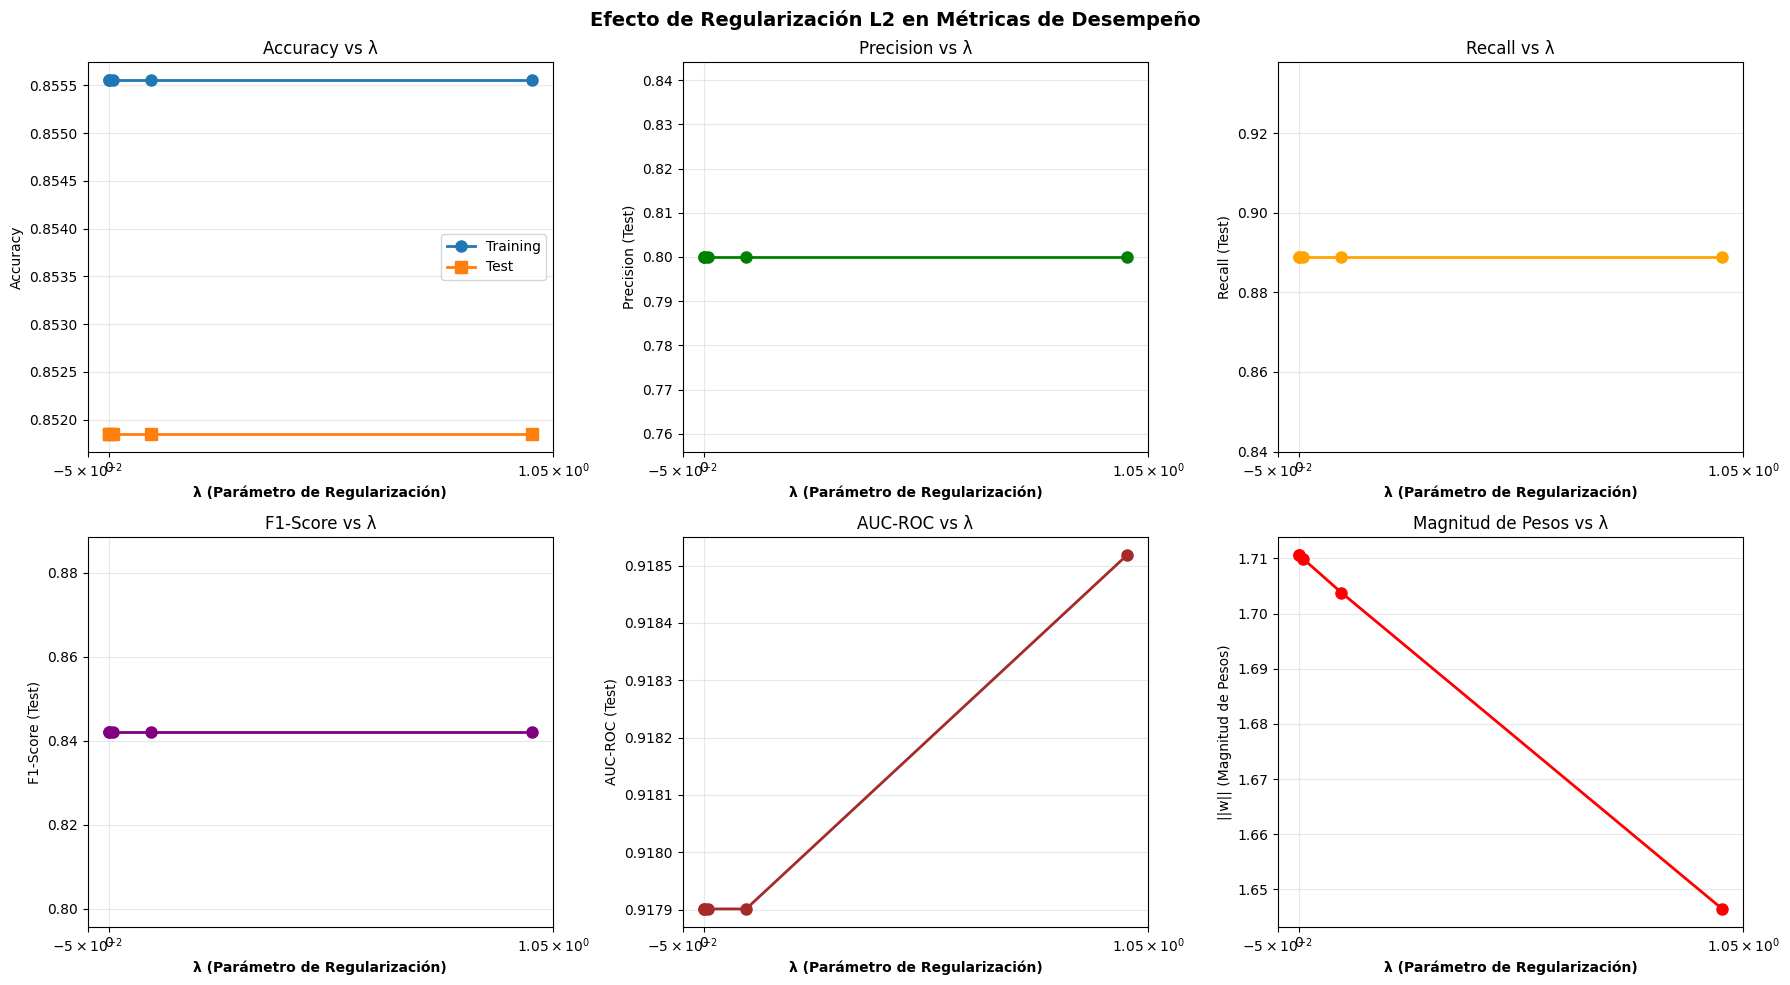


✓ Gráficos comparativos generados


In [153]:

# 5. VISUALIZACIÓN COMPARATIVA DE MÉTRICAS

print("\n5. GRÁFICOS COMPARATIVOS DE MÉTRICAS")
print("-" * 80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Accuracy
axes[0, 0].plot(lambda_values, results_df['Acc Train'], 'o-', label='Training', linewidth=2, markersize=8)
axes[0, 0].plot(lambda_values, results_df['Acc Test'], 's-', label='Test', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('λ (Parámetro de Regularización)', fontweight='bold')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Accuracy vs λ')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()
axes[0, 0].set_xscale('symlog')

# Precision
axes[0, 1].plot(lambda_values, results_df['Prec Test'], 'o-', color='green', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('λ (Parámetro de Regularización)', fontweight='bold')
axes[0, 1].set_ylabel('Precision (Test)')
axes[0, 1].set_title('Precision vs λ')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xscale('symlog')

# Recall
axes[0, 2].plot(lambda_values, results_df['Recall Test'], 'o-', color='orange', linewidth=2, markersize=8)
axes[0, 2].set_xlabel('λ (Parámetro de Regularización)', fontweight='bold')
axes[0, 2].set_ylabel('Recall (Test)')
axes[0, 2].set_title('Recall vs λ')
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].set_xscale('symlog')

# F1-Score
axes[1, 0].plot(lambda_values, results_df['F1 Test'], 'o-', color='purple', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('λ (Parámetro de Regularización)', fontweight='bold')
axes[1, 0].set_ylabel('F1-Score (Test)')
axes[1, 0].set_title('F1-Score vs λ')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xscale('symlog')

# AUC-ROC
axes[1, 1].plot(lambda_values, results_df['AUC Test'], 'o-', color='brown', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('λ (Parámetro de Regularización)', fontweight='bold')
axes[1, 1].set_ylabel('AUC-ROC (Test)')
axes[1, 1].set_title('AUC-ROC vs λ')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xscale('symlog')

# Magnitud de pesos ||w||
axes[1, 2].plot(lambda_values, results_df['||w||'], 'o-', color='red', linewidth=2, markersize=8)
axes[1, 2].set_xlabel('λ (Parámetro de Regularización)', fontweight='bold')
axes[1, 2].set_ylabel('||w|| (Magnitud de Pesos)')
axes[1, 2].set_title('Magnitud de Pesos vs λ')
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].set_xscale('symlog')

plt.suptitle('Efecto de Regularización L2 en Métricas de Desempeño',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ Gráficos comparativos generados")



In [158]:

# 4. TABLA COMPARATIVA DE MÉTRICAS

print("\n4. TABLA COMPARATIVA DE MÉTRICAS POR λ")
print("-" * 80)

# Crear DataFrame con resultados
results_df = pd.DataFrame({
    'λ': lambda_values,
    'Acc Train': [results_lambda[l]['acc_train'] for l in lambda_values],
    'Acc Test': [results_lambda[l]['acc_test'] for l in lambda_values],
    'Prec Test': [results_lambda[l]['prec_test'] for l in lambda_values],
    'Recall Test': [results_lambda[l]['rec_test'] for l in lambda_values],
    'F1 Test': [results_lambda[l]['f1_test'] for l in lambda_values],
    'AUC Test': [results_lambda[l]['auc_test'] for l in lambda_values],
    '||w||': [results_lambda[l]['w_magnitude'] for l in lambda_values],
    'Cost Final': [results_lambda[l]['cost_final'] for l in lambda_values]
})

print("\nResultados por λ:")
print(results_df.to_string(index=False))

# Encontrar λ óptimo para cada métrica
best_acc_test_idx = results_df['Acc Test'].idxmax()
best_f1_idx = results_df['F1 Test'].idxmax()
best_auc_idx = results_df['AUC Test'].idxmax()

best_lambda_acc = results_df.loc[best_acc_test_idx, 'λ']
best_lambda_f1 = results_df.loc[best_f1_idx, 'λ']
best_lambda_auc = results_df.loc[best_auc_idx, 'λ']

print(f"\n✓ Resumen de λ óptimos:")
print(f"  - Para Accuracy: λ = {best_lambda_acc} (Acc = {results_df.loc[best_acc_test_idx, 'Acc Test']:.4f})")
print(f"  - Para F1-Score: λ = {best_lambda_f1} (F1 = {results_df.loc[best_f1_idx, 'F1 Test']:.4f})")
print(f"  - Para AUC-ROC: λ = {best_lambda_auc} (AUC = {results_df.loc[best_auc_idx, 'AUC Test']:.4f})")




4. TABLA COMPARATIVA DE MÉTRICAS POR λ
--------------------------------------------------------------------------------

Resultados por λ:
    λ  Acc Train  Acc Test  Prec Test  Recall Test  F1 Test  AUC Test    ||w||  Cost Final
0.000   0.855556  0.851852        0.8     0.888889 0.842105  0.917901 1.710609    0.397596
0.001   0.855556  0.851852        0.8     0.888889 0.842105  0.917901 1.710540    0.397601
0.010   0.855556  0.851852        0.8     0.888889 0.842105  0.917901 1.709925    0.397652
0.100   0.855556  0.851852        0.8     0.888889 0.842105  0.917901 1.703814    0.398152
1.000   0.855556  0.851852        0.8     0.888889 0.842105  0.918519 1.646456    0.402947

✓ Resumen de λ óptimos:
  - Para Accuracy: λ = 0.0 (Acc = 0.8519)
  - Para F1-Score: λ = 0.0 (F1 = 0.8421)
  - Para AUC-ROC: λ = 1.0 (AUC = 0.9185)



3. COMPARACIÓN 2D: SIN REGULARIZACIÓN vs CON REGULARIZACIÓN
--------------------------------------------------------------------------------

Comparando par: Age vs Cholesterol


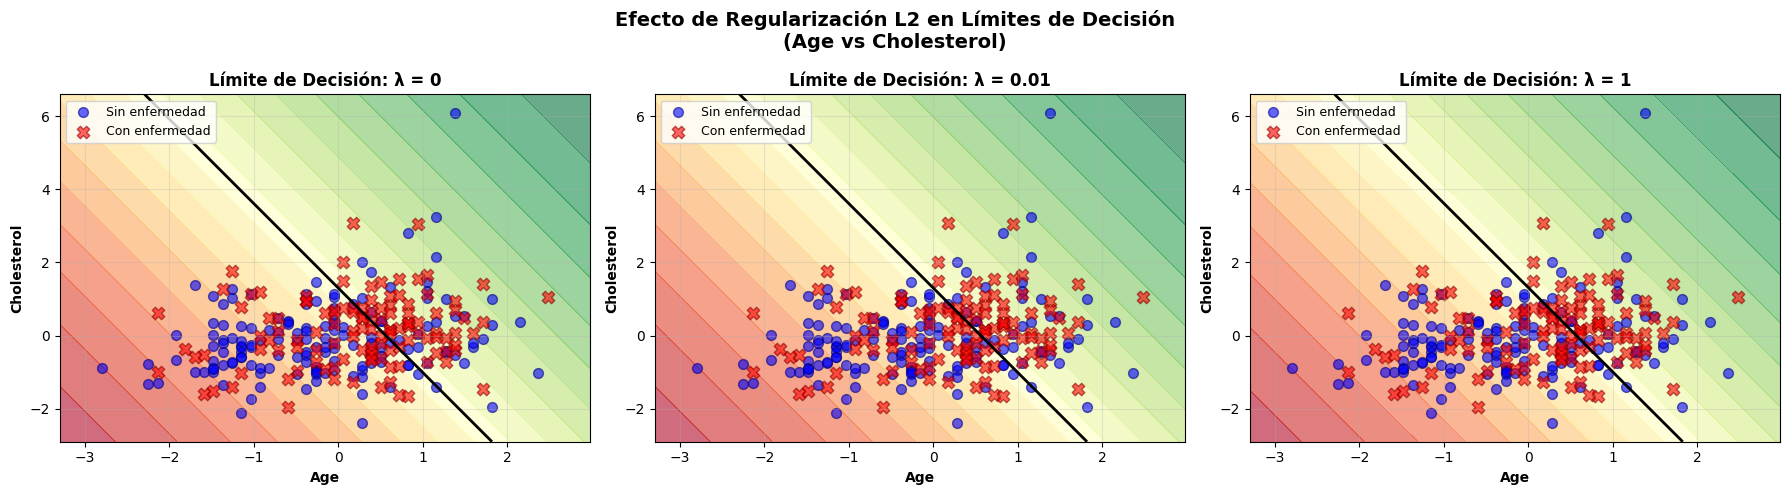


✓ Comparación 2D completada


In [159]:

# 3. COMPARACIÓN: SIN REGULARIZACIÓN vs CON REGULARIZACIÓN (UN PAR 2D)

print("\n3. COMPARACIÓN 2D: SIN REGULARIZACIÓN vs CON REGULARIZACIÓN")
print("-" * 80)

# Seleccionar un par para visualización
pair_to_compare = ('Age', 'Cholesterol')
feat1, feat2 = pair_to_compare

print(f"\nComparando par: {feat1} vs {feat2}")

# Extraer características 2D
X_pair = X_normalized_full[[feat1, feat2]].values

# Crear figura
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

lambda_to_plot = [0, 0.01, 1]

for idx, lambda_val in enumerate(lambda_to_plot):
    ax = axes[idx]
    
    # Entrenar modelo 2D con regularización
    w_init_2d = np.zeros(2)
    b_init_2d = 0
    
    # Descenso de gradiente 2D con L2
    w_2d_l2 = w_init_2d.copy()
    b_2d_l2 = b_init_2d
    
    for _ in range(1000):
        dw, db = compute_gradient_l2(X_pair, y.values, w_2d_l2, b_2d_l2, lambda_reg=lambda_val)
        w_2d_l2 -= 0.01 * dw
        b_2d_l2 -= 0.01 * db
    
    # Crear grid
    x_min, x_max = X_pair[:, 0].min() - 0.5, X_pair[:, 0].max() + 0.5
    y_min, y_max = X_pair[:, 1].min() - 0.5, X_pair[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    # Predicciones
    Z = sigmoid(np.c_[xx.ravel(), yy.ravel()] @ w_2d_l2 + b_2d_l2).reshape(xx.shape)
    
    # Graficar
    ax.contourf(xx, yy, Z, levels=20, cmap='RdYlGn', alpha=0.6)
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
    
    ax.scatter(X_pair[y.values == 0, 0], X_pair[y.values == 0, 1],
              c='blue', marker='o', edgecolors='navy', alpha=0.6, label='Sin enfermedad', s=50)
    ax.scatter(X_pair[y.values == 1, 0], X_pair[y.values == 1, 1],
              c='red', marker='X', edgecolors='darkred', alpha=0.6, label='Con enfermedad', s=80)
    
    ax.set_xlabel(feat1, fontweight='bold')
    ax.set_ylabel(feat2, fontweight='bold')
    ax.set_title(f'Límite de Decisión: λ = {lambda_val}', fontweight='bold', fontsize=12)
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Efecto de Regularización L2 en Límites de Decisión\n({feat1} vs {feat2})',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ Comparación 2D completada")




2. VISUALIZAR CONVERGENCIA PARA DIFERENTES λ
--------------------------------------------------------------------------------


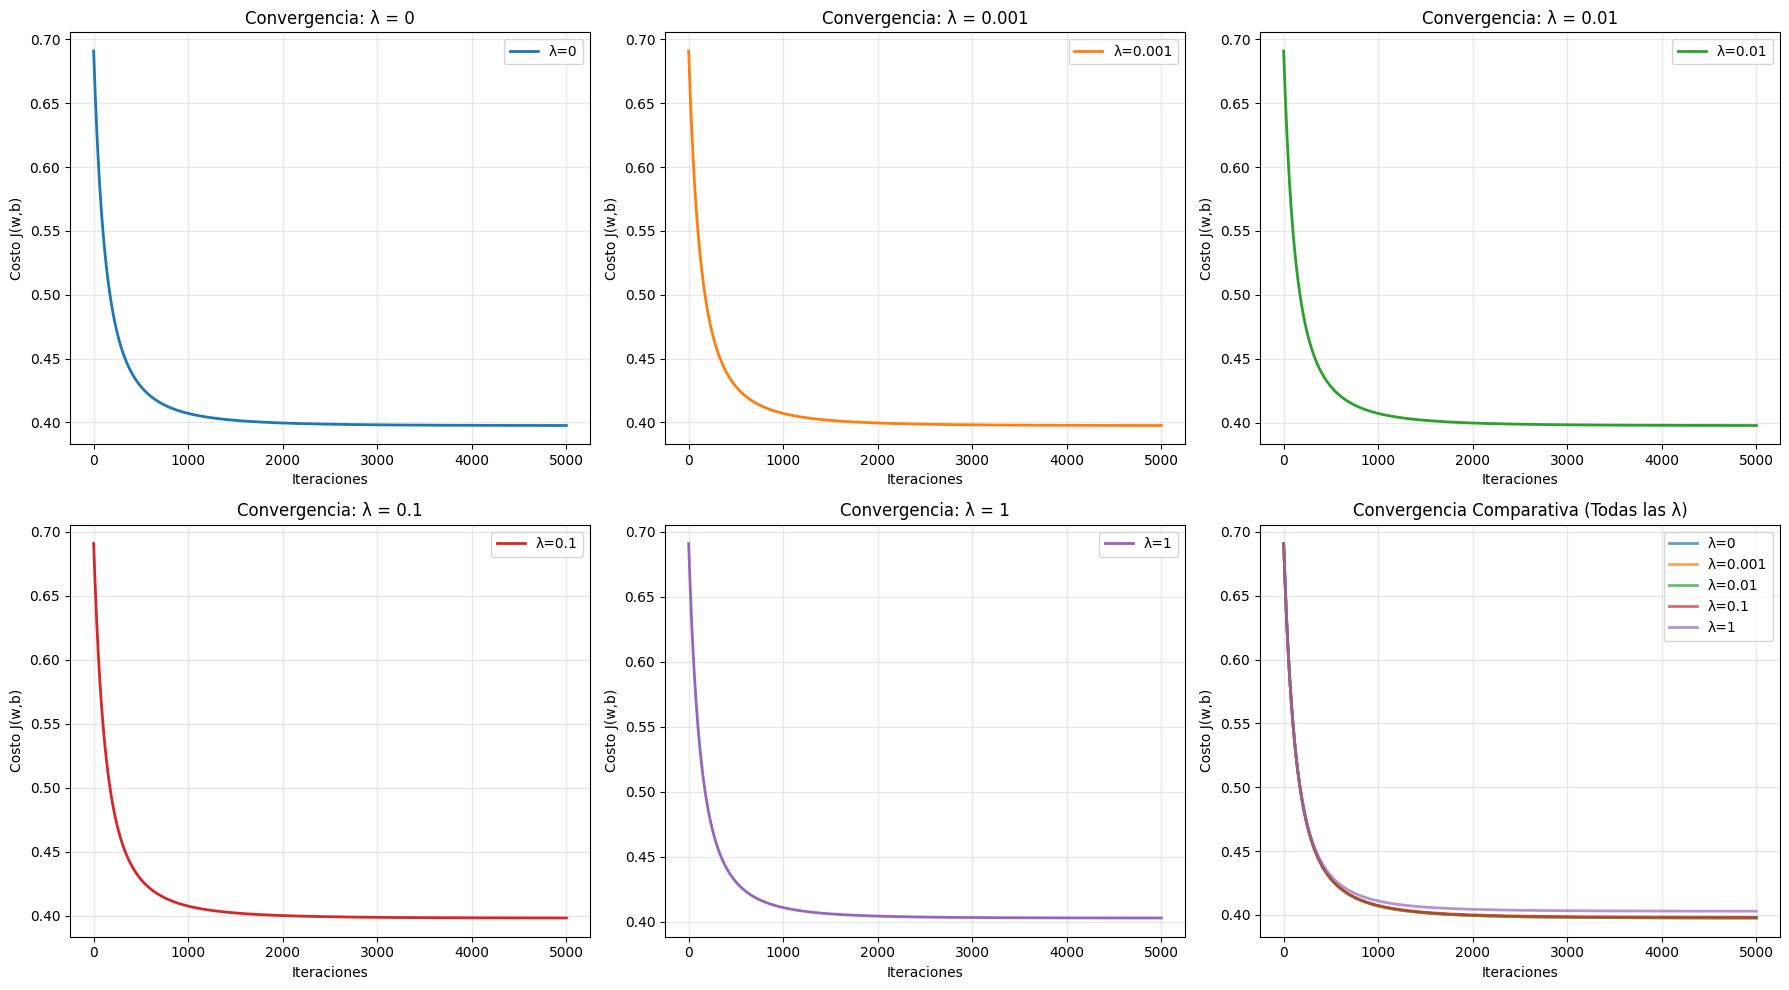

✓ Gráficos de convergencia generados


In [160]:

# 2. VISUALIZAR CONVERGENCIA COMPARATIVA

print("\n2. VISUALIZAR CONVERGENCIA PARA DIFERENTES λ")
print("-" * 80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, lambda_val in enumerate(lambda_values):
    ax = axes[idx]
    cost_hist = models_regularized[lambda_val]['cost_history']
    
    # Gráfico lineal (todas las iteraciones)
    ax.plot(cost_hist, linewidth=2, color=plt.cm.tab10(idx), label=f'λ={lambda_val}')
    ax.set_xlabel('Iteraciones')
    ax.set_ylabel('Costo J(w,b)')
    ax.set_title(f'Convergencia: λ = {lambda_val}')
    ax.grid(True, alpha=0.3)
    ax.legend()

# Gráfico comparativo de todas las λ
ax = axes[5]
for lambda_val in lambda_values:
    cost_hist = models_regularized[lambda_val]['cost_history']
    ax.plot(cost_hist, linewidth=2, label=f'λ={lambda_val}', alpha=0.7)

ax.set_xlabel('Iteraciones')
ax.set_ylabel('Costo J(w,b)')
ax.set_title('Convergencia Comparativa (Todas las λ)')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

print("✓ Gráficos de convergencia generados")

